In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import ScalarFormatter, FuncFormatter

from kan import create_dataset, KAN, KANLayer
from kan.MLP import MLP

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
def custom_formatter(x, pos):
    # Define a custom tick formatter function
    if abs(x) >= 1e4:
        return '{:.1e}'.format(x)
    else:
        return '{:.2f}'.format(x)


def plot_f_2d(f, N=1000, ct_levels=30, ct_cmap="viridis", ct_alpha=0.7, title='', figsize=(12, 9)):
    x = torch.linspace(-1.0, 1.0, N) 
    y = torch.linspace(-1.0, 1.0, N) 
    X, Y = torch.meshgrid(x, y, indexing=None) 
    
    input = torch.stack((X, Y), dim=2) #shape:[N, N, 2]
    input = torch.flatten(input, start_dim=0, end_dim=1) #shape: [N*N, 2]
    output = f(input).squeeze() #shape: [N*N, 2]
    Z = torch.unflatten(output, 0, [N, N]) #shape: [N, N]
    
    plt.figure(figsize=figsize)
    cont = plt.contourf(X, Y, Z, 
                        levels=ct_levels, 
                        cmap=ct_cmap, 
                        alpha=ct_alpha)
    cbar = plt.colorbar(cont)
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(title)
    
    plt.show() 


def plot_f_3d(f, N=1000, ct_levels=30, ct_cmap="viridis", ct_alpha=0.7, title='', figsize=(15, 12)):
    x = torch.linspace(-1.0, 1.0, N) 
    y = torch.linspace(-1.0, 1.0, N) 
    X, Y = torch.meshgrid(x, y, indexing=None) 
    
    input = torch.stack((X, Y), dim=2) #shape:[N, N, 2]
    input = torch.flatten(input, start_dim=0, end_dim=1) #shape: [N*N, 2]
    output = f(input).squeeze() #shape: [N*N, 2]
    Z = torch.unflatten(output, 0, [N, N]) #shape: [N, N]
    
    #cont = plt.contourf(X, Y, Z, 
    #                    levels=ct_levels, 
    #                    cmap=ct_cmap, 
    #                    alpha=ct_alpha)
    #cbar = plt.colorbar(cont)
  
    # Plot the function
    plt.rcParams.update({'font.size': 14})

    # Create a 3D plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap=ct_cmap, edgecolor='none', alpha=ct_alpha)

    # Add contours
    ax.contour(X, Y, Z, zdir='z', offset=torch.min(Z), cmap=ct_cmap, levels=ct_levels)

    # Add a color bar which maps values to colors
    cbar_ax = fig.add_axes([0.825, 0.175, 0.05, 0.55])
    cbar = fig.colorbar(surf, cax=cbar_ax, shrink=0.5, aspect=5,)
    # cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Function Value')
    #cbar.formatter = ScalarFormatter()
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-2, 2))
    
    # Apply the custom tick formatter to the color bar
    cbar_ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
    # Apply the custom tick formatter to the z-axis
    ax.zaxis.set_major_formatter(FuncFormatter(custom_formatter))

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(title)
    
    # Set the elevation and azimuth angles to adjust the viewing angle
    ax.view_init(elev=20, azim=-120)
    plt.show() 


def scatter_prediction_kan(model, 
                           x, 
                           y_true, 
                           title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.forward(x).detach().numpy()
    y_true = y_true.detach().numpy()
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=2, alpha = 0.2) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"RMSE={round(rmse, 5)} | MAE={round(mae, 5)} | R2={round(r2, 5)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()
    plt.close()
    
    return rmse, mae, r2


def kan_summary_after_fit(model, dataset, results, lmdKAN=False):
    model.forward(dataset['test_input'])
    model.plot()
    plt.show()
    plt.close()

    plt.plot(results['train_loss'], c='b')
    plt.plot(results['test_loss'], '--', c='b')
    plt.legend(['train', 'test'])
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.yscale('log')
    plt.show()
    plt.close()

    scatter_prediction_kan(model, dataset['test_input'], dataset['test_label'].reshape([-1,1]))
    
    if lmdKAN:
        plt.plot(np.arange(1, len(results['lmd'])+1), np.array(results['lmd'])[:,0], c='b')
        plt.plot(np.arange(1, len(results['lmd'])+1), np.array(results['lmd'])[:,1], c='r')
        plt.legend(['$\lambda_1$', '$\lambda_2$'])
        plt.ylabel('$\lambda$')
        plt.xlabel('step')
        #plt.yscale('log')
        plt.show()
        plt.close()

## $\lambda$-KAN

In [10]:
import random
import torch.nn as nn
import os
from kan.Symbolic_KANLayer import Symbolic_KANLayer
from tqdm import tqdm
from kan.LBFGS import LBFGS


class lmdKAN(KAN):
    '''
    KAN class
    
    Attributes:
    -----------
        grid : int
            the number of grid intervals
        k : int
            spline order
        act_fun : a list of KANLayers
        symbolic_fun: a list of Symbolic_KANLayer
        depth : int
            depth of KAN
        width : list
            number of neurons in each layer.
            Without multiplication nodes, [2,5,5,3] means 2D inputs, 3D outputs, with 2 layers of 5 hidden neurons.
            With multiplication nodes, [2,[5,3],[5,1],3] means besides the [2,5,53] KAN, there are 3 (1) mul nodes in layer 1 (2). 
        mult_arity : int, or list of int lists
            multiplication arity for each multiplication node (the number of numbers to be multiplied)
        grid : int
            the number of grid intervals
        k : int
            the order of piecewise polynomial
        base_fun : fun
            residual function b(x). an activation function phi(x) = sb_scale * b(x) + sp_scale * spline(x)
        symbolic_fun : a list of Symbolic_KANLayer
            Symbolic_KANLayers
        symbolic_enabled : bool
            If False, the symbolic front is not computed (to save time). Default: True.
        width_in : list
            The number of input neurons for each layer
        width_out : list
            The number of output neurons for each layer
        base_fun_name : str
            The base function b(x)
        grip_eps : float
            The parameter that interpolates between uniform grid and adaptive grid (based on sample quantile)
        node_bias : a list of 1D torch.float
        node_scale : a list of 1D torch.float
        subnode_bias : a list of 1D torch.float
        subnode_scale : a list of 1D torch.float
        symbolic_enabled : bool
            when symbolic_enabled = False, the symbolic branch (symbolic_fun) will be ignored in computation (set to zero)
        affine_trainable : bool
            indicate whether affine parameters are trainable (node_bias, node_scale, subnode_bias, subnode_scale)
        sp_trainable : bool
            indicate whether the overall magnitude of splines is trainable
        sb_trainable : bool
            indicate whether the overall magnitude of base function is trainable
        save_act : bool
            indicate whether intermediate activations are saved in forward pass
        node_scores : None or list of 1D torch.float
            node attribution score
        edge_scores : None or list of 2D torch.float
            edge attribution score
        subnode_scores : None or list of 1D torch.float
            subnode attribution score
        cache_data : None or 2D torch.float
            cached input data
        acts : None or a list of 2D torch.float
            activations on nodes
        auto_save : bool
            indicate whether to automatically save a checkpoint once the model is modified
        state_id : int
            the state of the model (used to save checkpoint)
        ckpt_path : str
            the folder to store checkpoints
        round : int
            the number of times rewind() has been called
        device : str
    '''
    def __init__(self, width=None, grid=3, k=3, mult_arity = 2, noise_scale=0.3, scale_base_mu=0.0, scale_base_sigma=1.0, base_fun='silu', symbolic_enabled=True, affine_trainable=False, grid_eps=0.02, grid_range=[-1, 1], sp_trainable=True, sb_trainable=True, seed=1, save_act=True, sparse_init=False, auto_save=True, first_init=True, ckpt_path='./model', state_id=0, round=0, device='cpu', lmd_init_vector=None, lmd_init_mu=0.0, lmd_init_sigma=1.0, lmd_trainable=True ):
        '''
        initalize a KAN model
        
        Args:
        -----
            width : list of int
                Without multiplication nodes: :math:`[n_0, n_1, .., n_{L-1}]` specify the number of neurons in each layer (including inputs/outputs)
                With multiplication nodes: :math:`[[n_0,m_0=0], [n_1,m_1], .., [n_{L-1},m_{L-1}]]` specify the number of addition/multiplication nodes in each layer (including inputs/outputs)
            grid : int
                number of grid intervals. Default: 3.
            k : int
                order of piecewise polynomial. Default: 3.
            mult_arity : int, or list of int lists
                multiplication arity for each multiplication node (the number of numbers to be multiplied)
            noise_scale : float
                initial injected noise to spline.
            base_fun : str
                the residual function b(x). Default: 'silu'
            symbolic_enabled : bool
                compute (True) or skip (False) symbolic computations (for efficiency). By default: True. 
            affine_trainable : bool
                affine parameters are updated or not. Affine parameters include node_scale, node_bias, subnode_scale, subnode_bias
            grid_eps : float
                When grid_eps = 1, the grid is uniform; when grid_eps = 0, the grid is partitioned using percentiles of samples. 0 < grid_eps < 1 interpolates between the two extremes.
            grid_range : list/np.array of shape (2,))
                setting the range of grids. Default: [-1,1]. This argument is not important if fit(update_grid=True) (by default updata_grid=True)
            sp_trainable : bool
                If true, scale_sp is trainable. Default: True.
            sb_trainable : bool
                If true, scale_base is trainable. Default: True.
            device : str
                device
            seed : int
                random seed
            save_act : bool
                indicate whether intermediate activations are saved in forward pass
            sparse_init : bool
                sparse initialization (True) or normal dense initialization. Default: False.
            auto_save : bool
                indicate whether to automatically save a checkpoint once the model is modified
            state_id : int
                the state of the model (used to save checkpoint)
            ckpt_path : str
                the folder to store checkpoints. Default: './model'
            round : int
                the number of times rewind() has been called
            device : str
            
        Returns:
        --------
            self
            
        Example
        -------
        >>> from kan import *
        >>> model = KAN(width=[2,5,1], grid=5, k=3, seed=0)
        checkpoint directory created: ./model
        saving model version 0.0
        '''
        super(KAN, self).__init__()

        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        ### initializeing the numerical front ###

        self.act_fun = []
        self.depth = len(width) - 1
        
        for i in range(len(width)):
            #print(type(width[i]), type(width[i]) == int)
            if type(width[i]) == int or type(width[i]) == np.int64:
                width[i] = [width[i],0]
            
        self.width = width
        
        # if mult_arity is just a scalar, we extend it to a list of lists
        # e.g, mult_arity = [[2,3],[4]] means that in the first hidden layer, 2 mult ops have arity 2 and 3, respectively;
        # in the second hidden layer, 1 mult op has arity 4.
        if isinstance(mult_arity, int):
            self.mult_homo = True # when homo is True, parallelization is possible
        else:
            self.mult_homo = False # when home if False, for loop is required. 
        self.mult_arity = mult_arity

        width_in = self.width_in
        width_out = self.width_out
        
        self.base_fun_name = base_fun
        if base_fun == 'silu':
            base_fun = torch.nn.SiLU()
        elif base_fun == 'identity':
            base_fun = torch.nn.Identity()
        elif base_fun == 'zero':
            base_fun = lambda x: x*0.
            
        self.grid_eps = grid_eps
        self.grid_range = grid_range
            
        
        for l in range(self.depth):
            # splines
            if isinstance(grid, list):
                grid_l = grid[l]
            else:
                grid_l = grid
                
            if isinstance(k, list):
                k_l = k[l]
            else:
                k_l = k
                    
            if l==0:
                sp_batch = lmdKANLayer(in_dim=width_in[l], out_dim=width_out[l+1], num=grid_l, k=k_l, noise_scale=noise_scale, lmd_init_vector=lmd_init_vector, lmd_init_mu=lmd_init_mu, lmd_init_sigma=lmd_init_sigma, lmd_trainable=lmd_trainable, scale_base_mu=scale_base_mu, scale_base_sigma=scale_base_sigma, scale_sp=1., base_fun=base_fun, grid_eps=grid_eps, grid_range=grid_range, sp_trainable=sp_trainable, sb_trainable=sb_trainable, sparse_init=sparse_init)
            else:
                sp_batch = KANLayer(in_dim=width_in[l], out_dim=width_out[l+1], num=grid_l, k=k_l, noise_scale=noise_scale, scale_base_mu=scale_base_mu, scale_base_sigma=scale_base_sigma, scale_sp=1., base_fun=base_fun, grid_eps=grid_eps, grid_range=grid_range, sp_trainable=sp_trainable, sb_trainable=sb_trainable, sparse_init=sparse_init)
            self.act_fun.append(sp_batch)

        self.node_bias = []
        self.node_scale = []
        self.subnode_bias = []
        self.subnode_scale = []
        
        globals()['self.node_bias_0'] = torch.nn.Parameter(torch.zeros(3,1)).requires_grad_(False)
        exec('self.node_bias_0' + " = torch.nn.Parameter(torch.zeros(3,1)).requires_grad_(False)")
        
        for l in range(self.depth):
            exec(f'self.node_bias_{l} = torch.nn.Parameter(torch.zeros(width_in[l+1])).requires_grad_(affine_trainable)')
            exec(f'self.node_scale_{l} = torch.nn.Parameter(torch.ones(width_in[l+1])).requires_grad_(affine_trainable)')
            exec(f'self.subnode_bias_{l} = torch.nn.Parameter(torch.zeros(width_out[l+1])).requires_grad_(affine_trainable)')
            exec(f'self.subnode_scale_{l} = torch.nn.Parameter(torch.ones(width_out[l+1])).requires_grad_(affine_trainable)')
            exec(f'self.node_bias.append(self.node_bias_{l})')
            exec(f'self.node_scale.append(self.node_scale_{l})')
            exec(f'self.subnode_bias.append(self.subnode_bias_{l})')
            exec(f'self.subnode_scale.append(self.subnode_scale_{l})')
            
        
        self.act_fun = nn.ModuleList(self.act_fun)

        self.grid = grid
        self.k = k
        self.base_fun = base_fun

        ### initializing the symbolic front ###
        self.symbolic_fun = []
        for l in range(self.depth):
            sb_batch = Symbolic_KANLayer(in_dim=width_in[l], out_dim=width_out[l+1])
            self.symbolic_fun.append(sb_batch)

        self.symbolic_fun = nn.ModuleList(self.symbolic_fun)
        self.symbolic_enabled = symbolic_enabled
        self.affine_trainable = affine_trainable
        self.sp_trainable = sp_trainable
        self.sb_trainable = sb_trainable
        
        self.save_act = save_act
            
        self.node_scores = None
        self.edge_scores = None
        self.subnode_scores = None
        
        self.cache_data = None
        self.acts = None
        
        self.auto_save = auto_save
        self.state_id = 0
        self.ckpt_path = ckpt_path
        self.round = round
        
        self.device = device
        self.to(device)
        
        if auto_save:
            if first_init:
                if not os.path.exists(ckpt_path):
                    # Create the directory
                    os.makedirs(ckpt_path)
                print(f"checkpoint directory created: {ckpt_path}")
                print('saving model version 0.0')

                history_path = self.ckpt_path+'/history.txt'
                with open(history_path, 'w') as file:
                    file.write(f'### Round {self.round} ###' + '\n')
                    file.write('init => 0.0' + '\n')
                self.saveckpt(path=self.ckpt_path+'/'+'0.0')
            else:
                self.state_id = state_id
            
        self.input_id = torch.arange(self.width_in[0],)
        
        
    def forward(self, x, singularity_avoiding=False, y_th=10.):
        '''
        forward pass
        
        Args:
        -----
            x : 2D torch.tensor
                inputs
            singularity_avoiding : bool
                whether to avoid singularity for the symbolic branch
            y_th : float
                the threshold for singularity

        Returns:
        --------
            None
            
        Example1
        --------
        >>> from kan import *
        >>> model = KAN(width=[2,5,1], grid=5, k=3, seed=0)
        >>> x = torch.rand(100,2)
        >>> model(x).shape
        
        Example2
        --------
        >>> from kan import *
        >>> model = KAN(width=[1,1], grid=5, k=3, seed=0)
        >>> x = torch.tensor([[1],[-0.01]])
        >>> model.fix_symbolic(0,0,0,'log',fit_params_bool=False)
        >>> print(model(x))
        >>> print(model(x, singularity_avoiding=True))
        >>> print(model(x, singularity_avoiding=True, y_th=1.))
        '''
        x = x[:,self.input_id.long()]
        assert x.shape[1] == self.width_in[0]
        
        # cache data
        self.cache_data = x
        
        self.acts = []  # shape ([batch, n0], [batch, n1], ..., [batch, n_L])
        self.acts_premult = []
        self.spline_preacts = []
        self.spline_postsplines = []
        self.spline_postacts = []
        self.acts_scale = []
        self.acts_scale_spline = []
        self.subnode_actscale = []
        self.edge_actscale = []
        # self.neurons_scale = []

        self.acts.append(x)  # acts shape: (batch, width[l])

        for l in range(self.depth):
            if l==0:
                x_numerical, preacts, postacts_numerical, postspline, beforelmd = self.act_fun[l](x)
                #self.beforelmd = beforelmd#.detach() # (batch, out_dim, in_dim)
            else:
                x_numerical, preacts, postacts_numerical, postspline = self.act_fun[l](x)
            #print(preacts, postacts_numerical, postspline)
            
            if self.symbolic_enabled == True:
                x_symbolic, postacts_symbolic = self.symbolic_fun[l](x, singularity_avoiding=singularity_avoiding, y_th=y_th)
            else:
                x_symbolic = 0.
                postacts_symbolic = 0.

            x = x_numerical + x_symbolic
            
            if self.save_act:
                # save subnode_scale
                self.subnode_actscale.append(torch.std(x, dim=0).detach())
            
            # subnode affine transform
            x = self.subnode_scale[l][None,:] * x + self.subnode_bias[l][None,:]
            
            if self.save_act:
                postacts = postacts_numerical + postacts_symbolic

                # self.neurons_scale.append(torch.mean(torch.abs(x), dim=0))
                #grid_reshape = self.act_fun[l].grid.reshape(self.width_out[l + 1], self.width_in[l], -1)
                input_range = torch.std(preacts, dim=0) + 0.1
                output_range_spline = torch.std(postacts_numerical, dim=0) # for training, only penalize the spline part
                output_range = torch.std(postacts, dim=0) # for visualization, include the contribution from both spline + symbolic
                # save edge_scale
                self.edge_actscale.append(output_range)
                
                self.acts_scale.append((output_range / input_range).detach())
                self.acts_scale_spline.append(output_range_spline / input_range)
                self.spline_preacts.append(preacts.detach())
                self.spline_postacts.append(postacts.detach())
                self.spline_postsplines.append(postspline.detach())

                self.acts_premult.append(x.detach())
                
                # block for lmd_corr regression
                if l==0: self.beforelmd = beforelmd # (batch, out_dim_0, in_dim_0)
                if l==1: self.postacts_for_lmd_reg = postacts # (batch, out_dim_1, in_dim_1), out_dim_0=in_dim_1
            
            
            # multiplication
            dim_sum = self.width[l+1][0]
            dim_mult = self.width[l+1][1]
            
            if self.mult_homo == True:
                for i in range(self.mult_arity-1):
                    if i == 0:
                        x_mult = x[:,dim_sum::self.mult_arity] * x[:,dim_sum+1::self.mult_arity]
                    else:
                        x_mult = x_mult * x[:,dim_sum+i+1::self.mult_arity]
                        
            else:
                for j in range(dim_mult):
                    acml_id = dim_sum + np.sum(self.mult_arity[l+1][:j])
                    for i in range(self.mult_arity[l+1][j]-1):
                        if i == 0:
                            x_mult_j = x[:,[acml_id]] * x[:,[acml_id+1]]
                        else:
                            x_mult_j = x_mult_j * x[:,[acml_id+i+1]]
                            
                    if j == 0:
                        x_mult = x_mult_j
                    else:
                        x_mult = torch.cat([x_mult, x_mult_j], dim=1)
                
            if self.width[l+1][1] > 0:
                x = torch.cat([x[:,:dim_sum], x_mult], dim=1)
            
            # x = x + self.biases[l].weight
            # node affine transform
            x = self.node_scale[l][None,:] * x + self.node_bias[l][None,:]
            
            self.acts.append(x.detach())
            
        
        return x
    
        
    def fit(self, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., lamb_lmd_interm=0.0, lamb_lmd_final=0.0, update_grid=True, grid_update_num=10, loss_fn=None, lr=1.,start_grid_update_step=-1, stop_grid_update_step=50, batch=-1,
              metrics=None, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', singularity_avoiding=False, y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None):
        '''
        training

        Args:
        -----
            dataset : dic
                contains dataset['train_input'], dataset['train_label'], dataset['test_input'], dataset['test_label']
            opt : str
                "LBFGS" or "Adam"
            steps : int
                training steps
            log : int
                logging frequency
            lamb : float
                overall penalty strength
            lamb_l1 : float
                l1 penalty strength
            lamb_entropy : float
                entropy penalty strength
            lamb_coef : float
                coefficient magnitude penalty strength
            lamb_coefdiff : float
                difference of nearby coefficits (smoothness) penalty strength
            update_grid : bool
                If True, update grid regularly before stop_grid_update_step
            grid_update_num : int
                the number of grid updates before stop_grid_update_step
            start_grid_update_step : int
                no grid updates before this training step
            stop_grid_update_step : int
                no grid updates after this training step
            loss_fn : function
                loss function
            lr : float
                learning rate
            batch : int
                batch size, if -1 then full.
            save_fig_freq : int
                save figure every (save_fig_freq) steps
            singularity_avoiding : bool
                indicate whether to avoid singularity for the symbolic part
            y_th : float
                singularity threshold (anything above the threshold is considered singular and is softened in some ways)
            reg_metric : str
                regularization metric. Choose from {'edge_forward_spline_n', 'edge_forward_spline_u', 'edge_forward_sum', 'edge_backward', 'node_backward'}
            metrics : a list of metrics (as functions)
                the metrics to be computed in training
            display_metrics : a list of functions
                the metric to be displayed in tqdm progress bar

        Returns:
        --------
            results : dic
                results['train_loss'], 1D array of training losses (RMSE)
                results['test_loss'], 1D array of test losses (RMSE)
                results['reg'], 1D array of regularization
                other metrics specified in metrics

        Example
        -------
        >>> from kan import *
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.3, seed=2)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001);
        >>> model.plot()
        # Most examples in toturals involve the fit() method. Please check them for useness.
        '''

        if lamb > 0. and not self.save_act:
            print('setting lamb=0. If you want to set lamb > 0, set self.save_act=True')
            
        old_save_act, old_symbolic_enabled = self.disable_symbolic_in_fit(lamb)

        pbar = tqdm(range(steps), desc='description', ncols=100)

        if loss_fn == None:
            loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
        else:
            loss_fn = loss_fn_eval = loss_fn

        grid_update_freq = int(stop_grid_update_step / grid_update_num)

        if opt == "Adam":
            optimizer = torch.optim.Adam(self.get_params(), lr=lr)
        elif opt == "LBFGS":
            optimizer = LBFGS(self.get_params(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

        results = {}
        results['train_loss'] = []
        results['test_loss'] = []
        results['reg'] = []
        results['lmd'] = []
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__] = []

        if batch == -1 or batch > dataset['train_input'].shape[0]:
            batch_size = dataset['train_input'].shape[0]
            batch_size_test = dataset['test_input'].shape[0]
        else:
            batch_size = batch
            batch_size_test = batch

        global train_loss, reg_

        def closure():
            global train_loss, reg_
            optimizer.zero_grad()
            pred = self.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
            train_loss = loss_fn(pred, dataset['train_label'][train_id])
            if self.save_act:
                if reg_metric == 'edge_backward':
                    self.attribute()
                if reg_metric == 'node_backward':
                    self.node_attribute()
                reg_ = self.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff, pred, lamb_lmd_interm, lamb_lmd_final)
            else:
                reg_ = torch.tensor(0.)
            objective = train_loss + lamb * reg_
            objective.backward()
            return objective

        if save_fig:
            if not os.path.exists(img_folder):
                os.makedirs(img_folder)

        for _ in pbar:
            
            if _ == steps-1 and old_save_act:
                self.save_act = True
                
            if save_fig and _ % save_fig_freq == 0:
                save_act = self.save_act
                self.save_act = True
            
            train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
            test_id = np.random.choice(dataset['test_input'].shape[0], batch_size_test, replace=False)

            if _ % grid_update_freq == 0 and _ < stop_grid_update_step and update_grid and _ >= start_grid_update_step:
                self.update_grid(dataset['train_input'][train_id])

            if opt == "LBFGS":
                optimizer.step(closure)

            if opt == "Adam":
                pred = self.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
                train_loss = loss_fn(pred, dataset['train_label'][train_id])
                if self.save_act:
                    if reg_metric == 'edge_backward':
                        self.attribute()
                    if reg_metric == 'node_backward':
                        self.node_attribute()
                    reg_ = self.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff, pred, lamb_lmd_interm, lamb_lmd_final)
                else:
                    reg_ = torch.tensor(0.)
                loss = train_loss + lamb * reg_
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            test_loss = loss_fn_eval(self.forward(dataset['test_input'][test_id]), dataset['test_label'][test_id])
            
            
            if metrics != None:
                for i in range(len(metrics)):
                    results[metrics[i].__name__].append(metrics[i]().item())

            results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
            results['test_loss'].append(torch.sqrt(test_loss).cpu().detach().numpy())
            results['reg'].append(reg_.cpu().detach().numpy())
            results['lmd'].append(self.act_fun[0].lmd.cpu().detach().clone().numpy())#
            #print(f'{self.act_fun[0].lmd.cpu().detach().numpy()=}')

            if _ % log == 0:
                if display_metrics == None:
                    pbar.set_description("| train_loss: %.2e | test_loss: %.2e | reg: %.2e | " % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(test_loss).cpu().detach().numpy(), reg_.cpu().detach().numpy()))
                else:
                    string = ''
                    data = ()
                    for metric in display_metrics:
                        string += f' {metric}: %.2e |'
                        try:
                            results[metric]
                        except:
                            raise Exception(f'{metric} not recognized')
                        data += (results[metric][-1],)
                    pbar.set_description(string % data)
                    
            
            if save_fig and _ % save_fig_freq == 0:
                self.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
                plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
                plt.close()
                self.save_act = save_act

        self.log_history('fit')
        # revert back to original state
        self.symbolic_enabled = old_symbolic_enabled
        return results
    
    
    def reg_lmd(self, pred, lamb_lmd_interm, lamb_lmd_final):
        '''
        Get regularization of correlation between lmd  
        
        Args:
        -----

        
        Returns:
        --------
            reg_ : torch.float
        
        Example
        -------
        >>> model = lmdKAN(width=[2,3,1], grid=5, k=3, noise_scale=1.)
        >>> x = torch.rand(100,2)
        >>> model.get_act(x)
        >>> model.reg_lmd()
        '''
        def pirson_corr(x, y):
            x_mean = torch.mean(x,dim=-1, keepdim=True)
            y_mean = torch.mean(y,dim=-1, keepdim=True)

            cov = torch.sum( (x - x_mean) * (y - y_mean), dim=-1 )

            disp_x2 = torch.sum( torch.square(x - x_mean), dim=-1 )
            disp_y2 = torch.sum( torch.square(y - y_mean), dim=-1 )

            corr = cov / torch.sqrt( disp_x2 * disp_y2 )

            return corr

        reg_interm_ = torch.mean( torch.square(pirson_corr(self.beforelmd.permute(2,1,0)[None,:,:,:], self.postacts_for_lmd_reg.permute(1,2,0)[:,None,:,:])) )
        reg_final_ = torch.mean( torch.square(pirson_corr(self.beforelmd.permute(2,1,0)[None,:,:,:], pred.permute(1,0)[None,None,:,:])) )


        return lamb_lmd_interm * reg_interm_ + lamb_lmd_final * reg_final_
    
    
    def get_reg(self, reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff, pred, lamb_lmd_interm, lamb_lmd_final):
        '''
        Get regularization. This seems unnecessary but in case a class wants to inherit this, it may want to rewrite get_reg, but not reg.
        '''
        return self.reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff) + self.reg_lmd(pred, lamb_lmd_interm, lamb_lmd_final)
    
    
    def lmd_corr_plot(self, fin_layer=False):
        if fin_layer:
            lmd_layer_acts, out_layer_acts = self.beforelmd.detach().clone(), self.acts[-1].detach().clone()
        else:
            lmd_layer_acts, out_layer_acts = self.beforelmd.detach().clone(), self.spline_postacts[1].detach().clone().squeeze()
    
        lmd_layer_acts = lmd_layer_acts.permute(2, 1, 0) #(in_dim, out_dim, N)
        out_layer_acts = out_layer_acts.permute(1, 0) #(out_dim, N)
    
        num_plots_horiz = lmd_layer_acts.shape[1]
        num_plots_vert = lmd_layer_acts.shape[0]
    
        out_layer_acts = out_layer_acts.expand(*lmd_layer_acts.shape)
    
        fig, ax = plt.subplots(num_plots_vert, num_plots_horiz, figsize=(27, 10))
        for num_v in range(num_plots_vert):
            for num_h in range(num_plots_horiz):
                x, y = lmd_layer_acts[num_v, num_h], out_layer_acts[num_v, num_h]
                ax[num_v, num_h].scatter(x, y)
                corr_matrix = torch.corrcoef(torch.concat((x[None,:], y[None,:]))).numpy()
                corr = corr_matrix[0,1] * corr_matrix[1,0]
                
                if num_v==num_plots_vert-1:
                    ax[num_v, num_h].set_xlabel(f'$\phi_{num_h+1}$', fontsize='large')
                if num_h==0:
                    ax[num_v, num_h].set_ylabel(f'$\Phi_{num_v+1}$', fontsize='large')
                    
                ax[num_v, num_h].set_title(f'$R^2=${round(float(corr), 5)}')
    
        plt.show()
        plt.close()

In [11]:
import random
import torch.nn as nn
import os
from kan.Symbolic_KANLayer import Symbolic_KANLayer
from tqdm import tqdm
from kan.LBFGS import LBFGS


class lmdKAN(KAN):
    '''
    KAN class
    
    Attributes:
    -----------
        grid : int
            the number of grid intervals
        k : int
            spline order
        act_fun : a list of KANLayers
        symbolic_fun: a list of Symbolic_KANLayer
        depth : int
            depth of KAN
        width : list
            number of neurons in each layer.
            Without multiplication nodes, [2,5,5,3] means 2D inputs, 3D outputs, with 2 layers of 5 hidden neurons.
            With multiplication nodes, [2,[5,3],[5,1],3] means besides the [2,5,53] KAN, there are 3 (1) mul nodes in layer 1 (2). 
        mult_arity : int, or list of int lists
            multiplication arity for each multiplication node (the number of numbers to be multiplied)
        grid : int
            the number of grid intervals
        k : int
            the order of piecewise polynomial
        base_fun : fun
            residual function b(x). an activation function phi(x) = sb_scale * b(x) + sp_scale * spline(x)
        symbolic_fun : a list of Symbolic_KANLayer
            Symbolic_KANLayers
        symbolic_enabled : bool
            If False, the symbolic front is not computed (to save time). Default: True.
        width_in : list
            The number of input neurons for each layer
        width_out : list
            The number of output neurons for each layer
        base_fun_name : str
            The base function b(x)
        grip_eps : float
            The parameter that interpolates between uniform grid and adaptive grid (based on sample quantile)
        node_bias : a list of 1D torch.float
        node_scale : a list of 1D torch.float
        subnode_bias : a list of 1D torch.float
        subnode_scale : a list of 1D torch.float
        symbolic_enabled : bool
            when symbolic_enabled = False, the symbolic branch (symbolic_fun) will be ignored in computation (set to zero)
        affine_trainable : bool
            indicate whether affine parameters are trainable (node_bias, node_scale, subnode_bias, subnode_scale)
        sp_trainable : bool
            indicate whether the overall magnitude of splines is trainable
        sb_trainable : bool
            indicate whether the overall magnitude of base function is trainable
        save_act : bool
            indicate whether intermediate activations are saved in forward pass
        node_scores : None or list of 1D torch.float
            node attribution score
        edge_scores : None or list of 2D torch.float
            edge attribution score
        subnode_scores : None or list of 1D torch.float
            subnode attribution score
        cache_data : None or 2D torch.float
            cached input data
        acts : None or a list of 2D torch.float
            activations on nodes
        auto_save : bool
            indicate whether to automatically save a checkpoint once the model is modified
        state_id : int
            the state of the model (used to save checkpoint)
        ckpt_path : str
            the folder to store checkpoints
        round : int
            the number of times rewind() has been called
        device : str
    '''
    def __init__(self, width=None, grid=3, k=3, mult_arity = 2, noise_scale=0.3, scale_base_mu=0.0, scale_base_sigma=1.0, base_fun='silu', symbolic_enabled=True, affine_trainable=False, grid_eps=0.02, grid_range=[-1, 1], sp_trainable=True, sb_trainable=True, seed=1, save_act=True, sparse_init=False, auto_save=True, first_init=True, ckpt_path='./model', state_id=0, round=0, device='cpu', lmd_init_vector=None, lmd_init_mu=0.0, lmd_init_sigma=1.0, lmd_trainable=True ):
        '''
        initalize a KAN model
        
        Args:
        -----
            width : list of int
                Without multiplication nodes: :math:`[n_0, n_1, .., n_{L-1}]` specify the number of neurons in each layer (including inputs/outputs)
                With multiplication nodes: :math:`[[n_0,m_0=0], [n_1,m_1], .., [n_{L-1},m_{L-1}]]` specify the number of addition/multiplication nodes in each layer (including inputs/outputs)
            grid : int
                number of grid intervals. Default: 3.
            k : int
                order of piecewise polynomial. Default: 3.
            mult_arity : int, or list of int lists
                multiplication arity for each multiplication node (the number of numbers to be multiplied)
            noise_scale : float
                initial injected noise to spline.
            base_fun : str
                the residual function b(x). Default: 'silu'
            symbolic_enabled : bool
                compute (True) or skip (False) symbolic computations (for efficiency). By default: True. 
            affine_trainable : bool
                affine parameters are updated or not. Affine parameters include node_scale, node_bias, subnode_scale, subnode_bias
            grid_eps : float
                When grid_eps = 1, the grid is uniform; when grid_eps = 0, the grid is partitioned using percentiles of samples. 0 < grid_eps < 1 interpolates between the two extremes.
            grid_range : list/np.array of shape (2,))
                setting the range of grids. Default: [-1,1]. This argument is not important if fit(update_grid=True) (by default updata_grid=True)
            sp_trainable : bool
                If true, scale_sp is trainable. Default: True.
            sb_trainable : bool
                If true, scale_base is trainable. Default: True.
            device : str
                device
            seed : int
                random seed
            save_act : bool
                indicate whether intermediate activations are saved in forward pass
            sparse_init : bool
                sparse initialization (True) or normal dense initialization. Default: False.
            auto_save : bool
                indicate whether to automatically save a checkpoint once the model is modified
            state_id : int
                the state of the model (used to save checkpoint)
            ckpt_path : str
                the folder to store checkpoints. Default: './model'
            round : int
                the number of times rewind() has been called
            device : str
            
        Returns:
        --------
            self
            
        Example
        -------
        >>> from kan import *
        >>> model = KAN(width=[2,5,1], grid=5, k=3, seed=0)
        checkpoint directory created: ./model
        saving model version 0.0
        '''
        super(KAN, self).__init__()

        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        ### initializeing the numerical front ###

        self.act_fun = []
        self.depth = len(width) - 1
        
        for i in range(len(width)):
            #print(type(width[i]), type(width[i]) == int)
            if type(width[i]) == int or type(width[i]) == np.int64:
                width[i] = [width[i],0]
            
        self.width = width
        
        # if mult_arity is just a scalar, we extend it to a list of lists
        # e.g, mult_arity = [[2,3],[4]] means that in the first hidden layer, 2 mult ops have arity 2 and 3, respectively;
        # in the second hidden layer, 1 mult op has arity 4.
        if isinstance(mult_arity, int):
            self.mult_homo = True # when homo is True, parallelization is possible
        else:
            self.mult_homo = False # when home if False, for loop is required. 
        self.mult_arity = mult_arity

        width_in = self.width_in
        width_out = self.width_out
        
        self.base_fun_name = base_fun
        if base_fun == 'silu':
            base_fun = torch.nn.SiLU()
        elif base_fun == 'identity':
            base_fun = torch.nn.Identity()
        elif base_fun == 'zero':
            base_fun = lambda x: x*0.
            
        self.grid_eps = grid_eps
        self.grid_range = grid_range
            
        
        for l in range(self.depth):
            # splines
            if isinstance(grid, list):
                grid_l = grid[l]
            else:
                grid_l = grid
                
            if isinstance(k, list):
                k_l = k[l]
            else:
                k_l = k
                    
            if l==0:
                sp_batch = lmdKANLayer(in_dim=width_in[l], out_dim=width_out[l+1], num=grid_l, k=k_l, noise_scale=noise_scale, lmd_init_vector=lmd_init_vector, lmd_init_mu=lmd_init_mu, lmd_init_sigma=lmd_init_sigma, lmd_trainable=lmd_trainable, scale_base_mu=scale_base_mu, scale_base_sigma=scale_base_sigma, scale_sp=1., base_fun=base_fun, grid_eps=grid_eps, grid_range=grid_range, sp_trainable=sp_trainable, sb_trainable=sb_trainable, sparse_init=sparse_init)
            else:
                sp_batch = KANLayer(in_dim=width_in[l], out_dim=width_out[l+1], num=grid_l, k=k_l, noise_scale=noise_scale, scale_base_mu=scale_base_mu, scale_base_sigma=scale_base_sigma, scale_sp=1., base_fun=base_fun, grid_eps=grid_eps, grid_range=grid_range, sp_trainable=sp_trainable, sb_trainable=sb_trainable, sparse_init=sparse_init)
            self.act_fun.append(sp_batch)

        self.node_bias = []
        self.node_scale = []
        self.subnode_bias = []
        self.subnode_scale = []
        
        globals()['self.node_bias_0'] = torch.nn.Parameter(torch.zeros(3,1)).requires_grad_(False)
        exec('self.node_bias_0' + " = torch.nn.Parameter(torch.zeros(3,1)).requires_grad_(False)")
        
        for l in range(self.depth):
            exec(f'self.node_bias_{l} = torch.nn.Parameter(torch.zeros(width_in[l+1])).requires_grad_(affine_trainable)')
            exec(f'self.node_scale_{l} = torch.nn.Parameter(torch.ones(width_in[l+1])).requires_grad_(affine_trainable)')
            exec(f'self.subnode_bias_{l} = torch.nn.Parameter(torch.zeros(width_out[l+1])).requires_grad_(affine_trainable)')
            exec(f'self.subnode_scale_{l} = torch.nn.Parameter(torch.ones(width_out[l+1])).requires_grad_(affine_trainable)')
            exec(f'self.node_bias.append(self.node_bias_{l})')
            exec(f'self.node_scale.append(self.node_scale_{l})')
            exec(f'self.subnode_bias.append(self.subnode_bias_{l})')
            exec(f'self.subnode_scale.append(self.subnode_scale_{l})')
            
        
        self.act_fun = nn.ModuleList(self.act_fun)

        self.grid = grid
        self.k = k
        self.base_fun = base_fun

        ### initializing the symbolic front ###
        self.symbolic_fun = []
        for l in range(self.depth):
            sb_batch = Symbolic_KANLayer(in_dim=width_in[l], out_dim=width_out[l+1])
            self.symbolic_fun.append(sb_batch)

        self.symbolic_fun = nn.ModuleList(self.symbolic_fun)
        self.symbolic_enabled = symbolic_enabled
        self.affine_trainable = affine_trainable
        self.sp_trainable = sp_trainable
        self.sb_trainable = sb_trainable
        
        self.save_act = save_act
            
        self.node_scores = None
        self.edge_scores = None
        self.subnode_scores = None
        
        self.cache_data = None
        self.acts = None
        
        self.auto_save = auto_save
        self.state_id = 0
        self.ckpt_path = ckpt_path
        self.round = round
        
        self.device = device
        self.to(device)
        
        if auto_save:
            if first_init:
                if not os.path.exists(ckpt_path):
                    # Create the directory
                    os.makedirs(ckpt_path)
                print(f"checkpoint directory created: {ckpt_path}")
                print('saving model version 0.0')

                history_path = self.ckpt_path+'/history.txt'
                with open(history_path, 'w') as file:
                    file.write(f'### Round {self.round} ###' + '\n')
                    file.write('init => 0.0' + '\n')
                self.saveckpt(path=self.ckpt_path+'/'+'0.0')
            else:
                self.state_id = state_id
            
        self.input_id = torch.arange(self.width_in[0],)
        
        
    def forward(self, x, singularity_avoiding=False, y_th=10.):
        '''
        forward pass
        
        Args:
        -----
            x : 2D torch.tensor
                inputs
            singularity_avoiding : bool
                whether to avoid singularity for the symbolic branch
            y_th : float
                the threshold for singularity

        Returns:
        --------
            None
            
        Example1
        --------
        >>> from kan import *
        >>> model = KAN(width=[2,5,1], grid=5, k=3, seed=0)
        >>> x = torch.rand(100,2)
        >>> model(x).shape
        
        Example2
        --------
        >>> from kan import *
        >>> model = KAN(width=[1,1], grid=5, k=3, seed=0)
        >>> x = torch.tensor([[1],[-0.01]])
        >>> model.fix_symbolic(0,0,0,'log',fit_params_bool=False)
        >>> print(model(x))
        >>> print(model(x, singularity_avoiding=True))
        >>> print(model(x, singularity_avoiding=True, y_th=1.))
        '''
        x = x[:,self.input_id.long()]
        assert x.shape[1] == self.width_in[0]
        
        # cache data
        self.cache_data = x
        
        self.acts = []  # shape ([batch, n0], [batch, n1], ..., [batch, n_L])
        self.acts_premult = []
        self.spline_preacts = []
        self.spline_postsplines = []
        self.spline_postacts = []
        self.acts_scale = []
        self.acts_scale_spline = []
        self.subnode_actscale = []
        self.edge_actscale = []
        # self.neurons_scale = []

        self.acts.append(x)  # acts shape: (batch, width[l])

        for l in range(self.depth):
            if l==0:
                x_numerical, preacts, postacts_numerical, postspline, beforelmd = self.act_fun[l](x)
                #self.beforelmd = beforelmd#.detach() # (batch, out_dim, in_dim)
            else:
                x_numerical, preacts, postacts_numerical, postspline = self.act_fun[l](x)
            #print(preacts, postacts_numerical, postspline)
            
            if self.symbolic_enabled == True:
                x_symbolic, postacts_symbolic = self.symbolic_fun[l](x, singularity_avoiding=singularity_avoiding, y_th=y_th)
            else:
                x_symbolic = 0.
                postacts_symbolic = 0.

            x = x_numerical + x_symbolic
            
            if self.save_act:
                # save subnode_scale
                self.subnode_actscale.append(torch.std(x, dim=0).detach())
            
            # subnode affine transform
            x = self.subnode_scale[l][None,:] * x + self.subnode_bias[l][None,:]
            
            if self.save_act:
                postacts = postacts_numerical + postacts_symbolic

                # self.neurons_scale.append(torch.mean(torch.abs(x), dim=0))
                #grid_reshape = self.act_fun[l].grid.reshape(self.width_out[l + 1], self.width_in[l], -1)
                input_range = torch.std(preacts, dim=0) + 0.1
                output_range_spline = torch.std(postacts_numerical, dim=0) # for training, only penalize the spline part
                output_range = torch.std(postacts, dim=0) # for visualization, include the contribution from both spline + symbolic
                # save edge_scale
                self.edge_actscale.append(output_range)
                
                self.acts_scale.append((output_range / input_range).detach())
                self.acts_scale_spline.append(output_range_spline / input_range)
                self.spline_preacts.append(preacts.detach())
                self.spline_postacts.append(postacts.detach())
                self.spline_postsplines.append(postspline.detach())

                self.acts_premult.append(x.detach())
                
                # block for lmd_corr regression
                if l==0: self.beforelmd = beforelmd # (batch, out_dim_0, in_dim_0)
                if l==1: self.postacts_for_lmd_reg = postacts # (batch, out_dim_1, in_dim_1), out_dim_0=in_dim_1
            
            
            # multiplication
            dim_sum = self.width[l+1][0]
            dim_mult = self.width[l+1][1]
            
            if self.mult_homo == True:
                for i in range(self.mult_arity-1):
                    if i == 0:
                        x_mult = x[:,dim_sum::self.mult_arity] * x[:,dim_sum+1::self.mult_arity]
                    else:
                        x_mult = x_mult * x[:,dim_sum+i+1::self.mult_arity]
                        
            else:
                for j in range(dim_mult):
                    acml_id = dim_sum + np.sum(self.mult_arity[l+1][:j])
                    for i in range(self.mult_arity[l+1][j]-1):
                        if i == 0:
                            x_mult_j = x[:,[acml_id]] * x[:,[acml_id+1]]
                        else:
                            x_mult_j = x_mult_j * x[:,[acml_id+i+1]]
                            
                    if j == 0:
                        x_mult = x_mult_j
                    else:
                        x_mult = torch.cat([x_mult, x_mult_j], dim=1)
                
            if self.width[l+1][1] > 0:
                x = torch.cat([x[:,:dim_sum], x_mult], dim=1)
            
            # x = x + self.biases[l].weight
            # node affine transform
            x = self.node_scale[l][None,:] * x + self.node_bias[l][None,:]
            
            self.acts.append(x.detach())
            
        
        return x
    
        
    def fit(self, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., lamb_lmd_interm=0.0, lamb_lmd_final=0.0, update_grid=True, grid_update_num=10, loss_fn=None, lr=1.,start_grid_update_step=-1, stop_grid_update_step=50, batch=-1,
              metrics=None, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', singularity_avoiding=False, y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None):
        '''
        training

        Args:
        -----
            dataset : dic
                contains dataset['train_input'], dataset['train_label'], dataset['test_input'], dataset['test_label']
            opt : str
                "LBFGS" or "Adam"
            steps : int
                training steps
            log : int
                logging frequency
            lamb : float
                overall penalty strength
            lamb_l1 : float
                l1 penalty strength
            lamb_entropy : float
                entropy penalty strength
            lamb_coef : float
                coefficient magnitude penalty strength
            lamb_coefdiff : float
                difference of nearby coefficits (smoothness) penalty strength
            update_grid : bool
                If True, update grid regularly before stop_grid_update_step
            grid_update_num : int
                the number of grid updates before stop_grid_update_step
            start_grid_update_step : int
                no grid updates before this training step
            stop_grid_update_step : int
                no grid updates after this training step
            loss_fn : function
                loss function
            lr : float
                learning rate
            batch : int
                batch size, if -1 then full.
            save_fig_freq : int
                save figure every (save_fig_freq) steps
            singularity_avoiding : bool
                indicate whether to avoid singularity for the symbolic part
            y_th : float
                singularity threshold (anything above the threshold is considered singular and is softened in some ways)
            reg_metric : str
                regularization metric. Choose from {'edge_forward_spline_n', 'edge_forward_spline_u', 'edge_forward_sum', 'edge_backward', 'node_backward'}
            metrics : a list of metrics (as functions)
                the metrics to be computed in training
            display_metrics : a list of functions
                the metric to be displayed in tqdm progress bar

        Returns:
        --------
            results : dic
                results['train_loss'], 1D array of training losses (RMSE)
                results['test_loss'], 1D array of test losses (RMSE)
                results['reg'], 1D array of regularization
                other metrics specified in metrics

        Example
        -------
        >>> from kan import *
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.3, seed=2)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001);
        >>> model.plot()
        # Most examples in toturals involve the fit() method. Please check them for useness.
        '''

        if lamb > 0. and not self.save_act:
            print('setting lamb=0. If you want to set lamb > 0, set self.save_act=True')
            
        old_save_act, old_symbolic_enabled = self.disable_symbolic_in_fit(lamb)

        pbar = tqdm(range(steps), desc='description', ncols=100)

        if loss_fn == None:
            loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
        else:
            loss_fn = loss_fn_eval = loss_fn

        grid_update_freq = int(stop_grid_update_step / grid_update_num)

        if opt == "Adam":
            optimizer = torch.optim.Adam(self.get_params(), lr=lr)
        elif opt == "LBFGS":
            optimizer = LBFGS(self.get_params(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

        results = {}
        results['train_loss'] = []
        results['test_loss'] = []
        results['reg'] = []
        results['lmd'] = []
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__] = []

        if batch == -1 or batch > dataset['train_input'].shape[0]:
            batch_size = dataset['train_input'].shape[0]
            batch_size_test = dataset['test_input'].shape[0]
        else:
            batch_size = batch
            batch_size_test = batch

        global train_loss, reg_

        def closure():
            global train_loss, reg_
            optimizer.zero_grad()
            pred = self.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
            train_loss = loss_fn(pred, dataset['train_label'][train_id])
            if self.save_act:
                if reg_metric == 'edge_backward':
                    self.attribute()
                if reg_metric == 'node_backward':
                    self.node_attribute()
                reg_ = self.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff, pred, lamb_lmd_interm, lamb_lmd_final)
            else:
                reg_ = torch.tensor(0.)
            objective = train_loss + lamb * reg_
            objective.backward()
            return objective

        if save_fig:
            if not os.path.exists(img_folder):
                os.makedirs(img_folder)

        for _ in pbar:
            
            if _ == steps-1 and old_save_act:
                self.save_act = True
                
            if save_fig and _ % save_fig_freq == 0:
                save_act = self.save_act
                self.save_act = True
            
            train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
            test_id = np.random.choice(dataset['test_input'].shape[0], batch_size_test, replace=False)

            if _ % grid_update_freq == 0 and _ < stop_grid_update_step and update_grid and _ >= start_grid_update_step:
                self.update_grid(dataset['train_input'][train_id])

            if opt == "LBFGS":
                optimizer.step(closure)

            if opt == "Adam":
                pred = self.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
                train_loss = loss_fn(pred, dataset['train_label'][train_id])
                if self.save_act:
                    if reg_metric == 'edge_backward':
                        self.attribute()
                    if reg_metric == 'node_backward':
                        self.node_attribute()
                    reg_ = self.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff, pred, lamb_lmd_interm, lamb_lmd_final)
                else:
                    reg_ = torch.tensor(0.)
                loss = train_loss + lamb * reg_
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            test_loss = loss_fn_eval(self.forward(dataset['test_input'][test_id]), dataset['test_label'][test_id])
            
            
            if metrics != None:
                for i in range(len(metrics)):
                    results[metrics[i].__name__].append(metrics[i]().item())

            results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
            results['test_loss'].append(torch.sqrt(test_loss).cpu().detach().numpy())
            results['reg'].append(reg_.cpu().detach().numpy())
            results['lmd'].append(self.act_fun[0].lmd.cpu().detach().clone().numpy())#
            #print(f'{self.act_fun[0].lmd.cpu().detach().numpy()=}')

            if _ % log == 0:
                if display_metrics == None:
                    pbar.set_description("| train_loss: %.2e | test_loss: %.2e | reg: %.2e | " % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(test_loss).cpu().detach().numpy(), reg_.cpu().detach().numpy()))
                else:
                    string = ''
                    data = ()
                    for metric in display_metrics:
                        string += f' {metric}: %.2e |'
                        try:
                            results[metric]
                        except:
                            raise Exception(f'{metric} not recognized')
                        data += (results[metric][-1],)
                    pbar.set_description(string % data)
                    
            
            if save_fig and _ % save_fig_freq == 0:
                self.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
                plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
                plt.close()
                self.save_act = save_act

        self.log_history('fit')
        # revert back to original state
        self.symbolic_enabled = old_symbolic_enabled
        return results
    
    
    def reg_lmd(self, pred, lamb_lmd_interm, lamb_lmd_final):
        '''
        Get regularization of correlation between lmd  
        
        Args:
        -----

        
        Returns:
        --------
            reg_ : torch.float
        
        Example
        -------
        >>> model = lmdKAN(width=[2,3,1], grid=5, k=3, noise_scale=1.)
        >>> x = torch.rand(100,2)
        >>> model.get_act(x)
        >>> model.reg_lmd()
        '''
        def pirson_corr(x, y):
            x_mean = torch.mean(x,dim=-1, keepdim=True)
            y_mean = torch.mean(y,dim=-1, keepdim=True)

            cov = torch.sum( (x - x_mean) * (y - y_mean), dim=-1 )

            disp_x2 = torch.sum( torch.square(x - x_mean), dim=-1 )
            disp_y2 = torch.sum( torch.square(y - y_mean), dim=-1 )

            corr = cov / torch.sqrt( disp_x2 * disp_y2 )

            return corr

        reg_interm_ = torch.mean( torch.square(pirson_corr(self.beforelmd.permute(2,1,0)[None,:,:,:], self.postacts_for_lmd_reg.permute(1,2,0)[:,None,:,:])) )
        reg_final_ = torch.mean( torch.square(pirson_corr(self.beforelmd.permute(2,1,0)[None,:,:,:], pred.permute(1,0)[None,None,:,:])) )


        return lamb_lmd_interm * reg_interm_ + lamb_lmd_final * reg_final_
    
    
    def get_reg(self, reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff, pred, lamb_lmd_interm, lamb_lmd_final):
        '''
        Get regularization. This seems unnecessary but in case a class wants to inherit this, it may want to rewrite get_reg, but not reg.
        '''
        return self.reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff) + self.reg_lmd(pred, lamb_lmd_interm, lamb_lmd_final)
    
    
    def lmd_corr_plot(self, fin_layer=False):
        if fin_layer:
            lmd_layer_acts, out_layer_acts = self.beforelmd.detach().clone(), self.acts[-1].detach().clone()
        else:
            lmd_layer_acts, out_layer_acts = self.beforelmd.detach().clone(), self.spline_postacts[1].detach().clone().squeeze()
    
        lmd_layer_acts = lmd_layer_acts.permute(2, 1, 0) #(in_dim, out_dim, N)
        out_layer_acts = out_layer_acts.permute(1, 0) #(out_dim, N)
    
        num_plots_horiz = lmd_layer_acts.shape[1]
        num_plots_vert = lmd_layer_acts.shape[0]
    
        out_layer_acts = out_layer_acts.expand(*lmd_layer_acts.shape)
    
        fig, ax = plt.subplots(num_plots_vert, num_plots_horiz, figsize=(27, 10))
        for num_v in range(num_plots_vert):
            for num_h in range(num_plots_horiz):
                x, y = lmd_layer_acts[num_v, num_h], out_layer_acts[num_v, num_h]
                ax[num_v, num_h].scatter(x, y)
                corr_matrix = torch.corrcoef(torch.concat((x[None,:], y[None,:]))).numpy()
                corr = corr_matrix[0,1] * corr_matrix[1,0]
                
                if num_v==num_plots_vert-1:
                    ax[num_v, num_h].set_xlabel(f'$\phi_{num_h+1}$', fontsize='large')
                if num_h==0:
                    ax[num_v, num_h].set_ylabel(f'$\Phi_{num_v+1}$', fontsize='large')
                    
                ax[num_v, num_h].set_title(f'$R^2=${round(float(corr), 5)}')
    
        plt.show()
        plt.close()

## $\lambda$-KAN

In [12]:
from kan.spline import *
from kan.utils import sparse_mask


class lmdKANLayer(KANLayer):
    """
    KANLayer class
    

    Attributes:
    -----------
        in_dim: int
            input dimension
        out_dim: int
            output dimension
        num: int
            the number of grid intervals
        k: int
            the piecewise polynomial order of splines
        noise_scale: float
            spline scale at initialization
        coef: 2D torch.tensor
            coefficients of B-spline bases
        scale_base_mu: float
            magnitude of the residual function b(x) is drawn from N(mu, sigma^2), mu = sigma_base_mu
        scale_base_sigma: float
            magnitude of the residual function b(x) is drawn from N(mu, sigma^2), mu = sigma_base_sigma
        scale_sp: float
            mangitude of the spline function spline(x)
        base_fun: fun
            residual function b(x)
        mask: 1D torch.float
            mask of spline functions. setting some element of the mask to zero means setting the corresponding activation to zero function.
        grid_eps: float in [0,1]
            a hyperparameter used in update_grid_from_samples. When grid_eps = 1, the grid is uniform; when grid_eps = 0, the grid is partitioned using percentiles of samples. 0 < grid_eps < 1 interpolates between the two extremes.
            the id of activation functions that are locked
        device: str
            device
    """

    def __init__(self, in_dim=3, out_dim=2, num=5, k=3, noise_scale=0.5, lmd_init_vector=None, lmd_init_mu=0.0, lmd_init_sigma=1.0, lmd_trainable=True , scale_base_mu=0.0, scale_base_sigma=1.0, scale_sp=1.0, base_fun=torch.nn.SiLU(), grid_eps=0.02, grid_range=[-1, 1], sp_trainable=True, sb_trainable=True, save_plot_data = True, device='cpu', sparse_init=False):
        ''''
        initialize a KANLayer
        
        Args:
        -----
            in_dim : int
                input dimension. Default: 2.
            out_dim : int
                output dimension. Default: 3.
            num : int
                the number of grid intervals = G. Default: 5.
            k : int
                the order of piecewise polynomial. Default: 3.
            noise_scale : float
                the scale of noise injected at initialization. Default: 0.1.
            scale_base_mu : float
                the scale of the residual function b(x) is intialized to be N(scale_base_mu, scale_base_sigma^2).
            scale_base_sigma : float
                the scale of the residual function b(x) is intialized to be N(scale_base_mu, scale_base_sigma^2).
            scale_sp : float
                the scale of the base function spline(x).
            base_fun : function
                residual function b(x). Default: torch.nn.SiLU()
            grid_eps : float
                When grid_eps = 1, the grid is uniform; when grid_eps = 0, the grid is partitioned using percentiles of samples. 0 < grid_eps < 1 interpolates between the two extremes.
            grid_range : list/np.array of shape (2,)
                setting the range of grids. Default: [-1,1].
            sp_trainable : bool
                If true, scale_sp is trainable
            sb_trainable : bool
                If true, scale_base is trainable
            device : str
                device
            sparse_init : bool
                if sparse_init = True, sparse initialization is applied.
            
        Returns:
        --------
            self
            
        Example
        -------
        >>> from kan.KANLayer import *
        >>> model = KANLayer(in_dim=3, out_dim=5)
        >>> (model.in_dim, model.out_dim)
        '''
        super(KANLayer, self).__init__()
        # size 
        self.out_dim = out_dim
        self.in_dim = in_dim
        self.num = num
        self.k = k

        grid = torch.linspace(grid_range[0], grid_range[1], steps=num + 1)[None,:].expand(1, num+1)
        grid = extend_grid(grid, k_extend=k)
        self.grid = torch.nn.Parameter(grid).requires_grad_(False)
        noises = (torch.rand(self.num+1, 1, self.out_dim) - 1/2) * noise_scale / num

        self.coef = torch.nn.Parameter(curve2coef(self.grid[:,k:-k].permute(1,0), noises, self.grid, k)) # (1, out_dim, num+k)
        
        if sparse_init:
            mask = sparse_mask(1, self.out_dim)
            self.mask_reduced_in_dim = torch.nn.Parameter(mask.clone()).requires_grad_(False)
            self.mask = torch.nn.Parameter(mask.expand(self.in_dim, self.out_dim).clone()).requires_grad_(False)
        else:
            mask = torch.ones(1, self.out_dim)
            self.mask_reduced_in_dim = torch.nn.Parameter(mask.clone()).requires_grad_(False)
            self.mask = torch.nn.Parameter(mask.expand(self.in_dim, self.out_dim).clone()).requires_grad_(False)
        
        
        self.scale_base = torch.nn.Parameter(scale_base_mu + \
                          scale_base_sigma * (torch.rand(1, self.out_dim)*2-1)).requires_grad_(sb_trainable) # (1, out_dim)
        #self.scale_base = torch.nn.Parameter(scale_base_mu * 1 / np.sqrt(in_dim) + \
        #                 scale_base_sigma * (torch.rand(in_dim, out_dim)*2-1) * 1/np.sqrt(in_dim)).requires_grad_(sb_trainable)
        
        self.scale_sp = torch.nn.Parameter(torch.ones(1, self.out_dim) * scale_sp * self.mask_reduced_in_dim).requires_grad_(sp_trainable)  # make scale trainable
        #self.scale_sp = torch.nn.Parameter(torch.ones(in_dim, out_dim) * scale_sp * 1 / np.sqrt(in_dim) * self.mask).requires_grad_(sp_trainable)  # make scale trainable
        
        if lmd_init_vector==None:
            # Initialize lmd with ones
            self.lmd = torch.nn.Parameter(torch.ones(self.in_dim)).requires_grad_(lmd_trainable)
            # Initialize lmd with uniform distr [-1,1]
            #self.lmd = torch.nn.Parameter(lmd_init_mu + \
            #                              lmd_init_sigma * (torch.rand(self.in_dim)*2-1)).requires_grad_(lmd_trainable)
        else:
            self.lmd = torch.nn.Parameter(torch.Tensor(lmd_init_vector)).requires_grad_(lmd_trainable)
        
        self.base_fun = base_fun
        self.grid_eps = grid_eps
        
        self.to(device)
    

    def forward(self, x):
        '''
        KANLayer forward given input x
        
        Args:
        -----
            x : 2D torch.float
                inputs, shape (number of samples, input dimension)
            
        Returns:
        --------
            y : 2D torch.float
                outputs, shape (number of samples, output dimension)
            preacts : 3D torch.float
                fan out x into activations, shape (number of sampels, output dimension, input dimension)
            postacts : 3D torch.float
                the outputs of activation functions with preacts as inputs
            postspline : 3D torch.float
                the outputs of spline functions with preacts as inputs
        
        Example
        -------
        >>> from kan.KANLayer import *
        >>> model = KANLayer(in_dim=3, out_dim=5)
        >>> x = torch.normal(0,1,size=(100,3))
        >>> y, preacts, postacts, postspline = model(x)
        >>> y.shape, preacts.shape, postacts.shape, postspline.shape
        '''
        batch = x.shape[0]
        preacts = x[:,None,:].clone().expand(batch, self.out_dim, self.in_dim) # (batch, out_dim, in_dim)
            
        base = self.base_fun(x) # (batch, in_dim)
        y = coef2curve(x_eval=x, grid=self.grid, coef=self.coef, k=self.k) # (batch, in_dim, out_dim)
        
        postspline = y.clone().permute(0,2,1) # (batch, out_dim, in_dim)
            
        y = self.scale_base[None,:,:] * base[:,:,None] + self.scale_sp[None,:,:] * y # (batch, in_dim, out_dim)
        beforelmd = y.clone().permute(0,2,1) # (batch, out_dim, in_dim)
        
        y = self.lmd[None,:,None] * y
        y = self.mask[None,:,:] * y # (batch, in_dim, out_dim)
        
        postacts = y.clone().permute(0,2,1) # (batch, out_dim, in_dim)
            
        y = torch.sum(y, dim=1) # (batch, out_dim)
        return y, preacts, postacts, postspline, beforelmd
    
    
    def update_grid_from_samples(self, x, mode='sample'):
        '''
        update grid from samples
        
        Args:
        -----
            x : 2D torch.float
                inputs, shape (number of samples, input dimension)
            
        Returns:
        --------
            None
        
        Example
        -------
        >>> model = KANLayer(in_dim=1, out_dim=1, num=5, k=3)
        >>> print(model.grid.data)
        >>> x = torch.linspace(-3,3,steps=100)[:,None]
        >>> model.update_grid_from_samples(x)
        >>> print(model.grid.data)
        '''
        
        batch = x.shape[0]
        #x = torch.einsum('ij,k->ikj', x, torch.ones(self.out_dim, ).to(self.device)).reshape(batch, self.size).permute(1, 0)
        x_pos = torch.sort(x, dim=0)[0]
        y_eval = coef2curve(x_pos, self.grid, self.coef, self.k)
        num_interval = self.grid.shape[1] - 1 - 2*self.k
        
        def get_grid(num_interval):
            ids = [int(batch / num_interval * i) for i in range(num_interval)] + [-1]
            grid_adaptive = x_pos[ids, :].permute(1,0)
            margin = 0.00
            h = (grid_adaptive[:,[-1]] - grid_adaptive[:,[0]] + 2 * margin)/num_interval
            grid_uniform = grid_adaptive[:,[0]] - margin + h * torch.arange(num_interval+1,)[None, :].to(x.device)
            grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
            return grid
        
        
        grid = get_grid(num_interval)
        
        if mode == 'grid':
            sample_grid = get_grid(2*num_interval)
            x_pos = sample_grid.permute(1,0)
            y_eval = coef2curve(x_pos, self.grid, self.coef, self.k)
        
        self.grid.data = extend_grid(grid, k_extend=self.k)
        #print('x_pos 2', x_pos.shape)
        #print('y_eval 2', y_eval.shape)
        self.coef.data = curve2coef(x_pos, y_eval, self.grid, self.k).mean(axis=0).expand(1, self.out_dim, self.num+self.k)

In [13]:
import random
import torch.nn as nn
import os
from kan.Symbolic_KANLayer import Symbolic_KANLayer
from tqdm import tqdm
from kan.LBFGS import LBFGS


class lmdKAN(KAN):
    '''
    KAN class
    
    Attributes:
    -----------
        grid : int
            the number of grid intervals
        k : int
            spline order
        act_fun : a list of KANLayers
        symbolic_fun: a list of Symbolic_KANLayer
        depth : int
            depth of KAN
        width : list
            number of neurons in each layer.
            Without multiplication nodes, [2,5,5,3] means 2D inputs, 3D outputs, with 2 layers of 5 hidden neurons.
            With multiplication nodes, [2,[5,3],[5,1],3] means besides the [2,5,53] KAN, there are 3 (1) mul nodes in layer 1 (2). 
        mult_arity : int, or list of int lists
            multiplication arity for each multiplication node (the number of numbers to be multiplied)
        grid : int
            the number of grid intervals
        k : int
            the order of piecewise polynomial
        base_fun : fun
            residual function b(x). an activation function phi(x) = sb_scale * b(x) + sp_scale * spline(x)
        symbolic_fun : a list of Symbolic_KANLayer
            Symbolic_KANLayers
        symbolic_enabled : bool
            If False, the symbolic front is not computed (to save time). Default: True.
        width_in : list
            The number of input neurons for each layer
        width_out : list
            The number of output neurons for each layer
        base_fun_name : str
            The base function b(x)
        grip_eps : float
            The parameter that interpolates between uniform grid and adaptive grid (based on sample quantile)
        node_bias : a list of 1D torch.float
        node_scale : a list of 1D torch.float
        subnode_bias : a list of 1D torch.float
        subnode_scale : a list of 1D torch.float
        symbolic_enabled : bool
            when symbolic_enabled = False, the symbolic branch (symbolic_fun) will be ignored in computation (set to zero)
        affine_trainable : bool
            indicate whether affine parameters are trainable (node_bias, node_scale, subnode_bias, subnode_scale)
        sp_trainable : bool
            indicate whether the overall magnitude of splines is trainable
        sb_trainable : bool
            indicate whether the overall magnitude of base function is trainable
        save_act : bool
            indicate whether intermediate activations are saved in forward pass
        node_scores : None or list of 1D torch.float
            node attribution score
        edge_scores : None or list of 2D torch.float
            edge attribution score
        subnode_scores : None or list of 1D torch.float
            subnode attribution score
        cache_data : None or 2D torch.float
            cached input data
        acts : None or a list of 2D torch.float
            activations on nodes
        auto_save : bool
            indicate whether to automatically save a checkpoint once the model is modified
        state_id : int
            the state of the model (used to save checkpoint)
        ckpt_path : str
            the folder to store checkpoints
        round : int
            the number of times rewind() has been called
        device : str
    '''
    def __init__(self, width=None, grid=3, k=3, mult_arity = 2, noise_scale=0.3, scale_base_mu=0.0, scale_base_sigma=1.0, base_fun='silu', symbolic_enabled=True, affine_trainable=False, grid_eps=0.02, grid_range=[-1, 1], sp_trainable=True, sb_trainable=True, seed=1, save_act=True, sparse_init=False, auto_save=True, first_init=True, ckpt_path='./model', state_id=0, round=0, device='cpu', lmd_init_vector=None, lmd_init_mu=0.0, lmd_init_sigma=1.0, lmd_trainable=True ):
        '''
        initalize a KAN model
        
        Args:
        -----
            width : list of int
                Without multiplication nodes: :math:`[n_0, n_1, .., n_{L-1}]` specify the number of neurons in each layer (including inputs/outputs)
                With multiplication nodes: :math:`[[n_0,m_0=0], [n_1,m_1], .., [n_{L-1},m_{L-1}]]` specify the number of addition/multiplication nodes in each layer (including inputs/outputs)
            grid : int
                number of grid intervals. Default: 3.
            k : int
                order of piecewise polynomial. Default: 3.
            mult_arity : int, or list of int lists
                multiplication arity for each multiplication node (the number of numbers to be multiplied)
            noise_scale : float
                initial injected noise to spline.
            base_fun : str
                the residual function b(x). Default: 'silu'
            symbolic_enabled : bool
                compute (True) or skip (False) symbolic computations (for efficiency). By default: True. 
            affine_trainable : bool
                affine parameters are updated or not. Affine parameters include node_scale, node_bias, subnode_scale, subnode_bias
            grid_eps : float
                When grid_eps = 1, the grid is uniform; when grid_eps = 0, the grid is partitioned using percentiles of samples. 0 < grid_eps < 1 interpolates between the two extremes.
            grid_range : list/np.array of shape (2,))
                setting the range of grids. Default: [-1,1]. This argument is not important if fit(update_grid=True) (by default updata_grid=True)
            sp_trainable : bool
                If true, scale_sp is trainable. Default: True.
            sb_trainable : bool
                If true, scale_base is trainable. Default: True.
            device : str
                device
            seed : int
                random seed
            save_act : bool
                indicate whether intermediate activations are saved in forward pass
            sparse_init : bool
                sparse initialization (True) or normal dense initialization. Default: False.
            auto_save : bool
                indicate whether to automatically save a checkpoint once the model is modified
            state_id : int
                the state of the model (used to save checkpoint)
            ckpt_path : str
                the folder to store checkpoints. Default: './model'
            round : int
                the number of times rewind() has been called
            device : str
            
        Returns:
        --------
            self
            
        Example
        -------
        >>> from kan import *
        >>> model = KAN(width=[2,5,1], grid=5, k=3, seed=0)
        checkpoint directory created: ./model
        saving model version 0.0
        '''
        super(KAN, self).__init__()

        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        ### initializeing the numerical front ###

        self.act_fun = []
        self.depth = len(width) - 1
        
        for i in range(len(width)):
            #print(type(width[i]), type(width[i]) == int)
            if type(width[i]) == int or type(width[i]) == np.int64:
                width[i] = [width[i],0]
            
        self.width = width
        
        # if mult_arity is just a scalar, we extend it to a list of lists
        # e.g, mult_arity = [[2,3],[4]] means that in the first hidden layer, 2 mult ops have arity 2 and 3, respectively;
        # in the second hidden layer, 1 mult op has arity 4.
        if isinstance(mult_arity, int):
            self.mult_homo = True # when homo is True, parallelization is possible
        else:
            self.mult_homo = False # when home if False, for loop is required. 
        self.mult_arity = mult_arity

        width_in = self.width_in
        width_out = self.width_out
        
        self.base_fun_name = base_fun
        if base_fun == 'silu':
            base_fun = torch.nn.SiLU()
        elif base_fun == 'identity':
            base_fun = torch.nn.Identity()
        elif base_fun == 'zero':
            base_fun = lambda x: x*0.
            
        self.grid_eps = grid_eps
        self.grid_range = grid_range
            
        
        for l in range(self.depth):
            # splines
            if isinstance(grid, list):
                grid_l = grid[l]
            else:
                grid_l = grid
                
            if isinstance(k, list):
                k_l = k[l]
            else:
                k_l = k
                    
            if l==0:
                sp_batch = lmdKANLayer(in_dim=width_in[l], out_dim=width_out[l+1], num=grid_l, k=k_l, noise_scale=noise_scale, lmd_init_vector=lmd_init_vector, lmd_init_mu=lmd_init_mu, lmd_init_sigma=lmd_init_sigma, lmd_trainable=lmd_trainable, scale_base_mu=scale_base_mu, scale_base_sigma=scale_base_sigma, scale_sp=1., base_fun=base_fun, grid_eps=grid_eps, grid_range=grid_range, sp_trainable=sp_trainable, sb_trainable=sb_trainable, sparse_init=sparse_init)
            else:
                sp_batch = KANLayer(in_dim=width_in[l], out_dim=width_out[l+1], num=grid_l, k=k_l, noise_scale=noise_scale, scale_base_mu=scale_base_mu, scale_base_sigma=scale_base_sigma, scale_sp=1., base_fun=base_fun, grid_eps=grid_eps, grid_range=grid_range, sp_trainable=sp_trainable, sb_trainable=sb_trainable, sparse_init=sparse_init)
            self.act_fun.append(sp_batch)

        self.node_bias = []
        self.node_scale = []
        self.subnode_bias = []
        self.subnode_scale = []
        
        globals()['self.node_bias_0'] = torch.nn.Parameter(torch.zeros(3,1)).requires_grad_(False)
        exec('self.node_bias_0' + " = torch.nn.Parameter(torch.zeros(3,1)).requires_grad_(False)")
        
        for l in range(self.depth):
            exec(f'self.node_bias_{l} = torch.nn.Parameter(torch.zeros(width_in[l+1])).requires_grad_(affine_trainable)')
            exec(f'self.node_scale_{l} = torch.nn.Parameter(torch.ones(width_in[l+1])).requires_grad_(affine_trainable)')
            exec(f'self.subnode_bias_{l} = torch.nn.Parameter(torch.zeros(width_out[l+1])).requires_grad_(affine_trainable)')
            exec(f'self.subnode_scale_{l} = torch.nn.Parameter(torch.ones(width_out[l+1])).requires_grad_(affine_trainable)')
            exec(f'self.node_bias.append(self.node_bias_{l})')
            exec(f'self.node_scale.append(self.node_scale_{l})')
            exec(f'self.subnode_bias.append(self.subnode_bias_{l})')
            exec(f'self.subnode_scale.append(self.subnode_scale_{l})')
            
        
        self.act_fun = nn.ModuleList(self.act_fun)

        self.grid = grid
        self.k = k
        self.base_fun = base_fun

        ### initializing the symbolic front ###
        self.symbolic_fun = []
        for l in range(self.depth):
            sb_batch = Symbolic_KANLayer(in_dim=width_in[l], out_dim=width_out[l+1])
            self.symbolic_fun.append(sb_batch)

        self.symbolic_fun = nn.ModuleList(self.symbolic_fun)
        self.symbolic_enabled = symbolic_enabled
        self.affine_trainable = affine_trainable
        self.sp_trainable = sp_trainable
        self.sb_trainable = sb_trainable
        
        self.save_act = save_act
            
        self.node_scores = None
        self.edge_scores = None
        self.subnode_scores = None
        
        self.cache_data = None
        self.acts = None
        
        self.auto_save = auto_save
        self.state_id = 0
        self.ckpt_path = ckpt_path
        self.round = round
        
        self.device = device
        self.to(device)
        
        if auto_save:
            if first_init:
                if not os.path.exists(ckpt_path):
                    # Create the directory
                    os.makedirs(ckpt_path)
                print(f"checkpoint directory created: {ckpt_path}")
                print('saving model version 0.0')

                history_path = self.ckpt_path+'/history.txt'
                with open(history_path, 'w') as file:
                    file.write(f'### Round {self.round} ###' + '\n')
                    file.write('init => 0.0' + '\n')
                self.saveckpt(path=self.ckpt_path+'/'+'0.0')
            else:
                self.state_id = state_id
            
        self.input_id = torch.arange(self.width_in[0],)
        
        
    def forward(self, x, singularity_avoiding=False, y_th=10.):
        '''
        forward pass
        
        Args:
        -----
            x : 2D torch.tensor
                inputs
            singularity_avoiding : bool
                whether to avoid singularity for the symbolic branch
            y_th : float
                the threshold for singularity

        Returns:
        --------
            None
            
        Example1
        --------
        >>> from kan import *
        >>> model = KAN(width=[2,5,1], grid=5, k=3, seed=0)
        >>> x = torch.rand(100,2)
        >>> model(x).shape
        
        Example2
        --------
        >>> from kan import *
        >>> model = KAN(width=[1,1], grid=5, k=3, seed=0)
        >>> x = torch.tensor([[1],[-0.01]])
        >>> model.fix_symbolic(0,0,0,'log',fit_params_bool=False)
        >>> print(model(x))
        >>> print(model(x, singularity_avoiding=True))
        >>> print(model(x, singularity_avoiding=True, y_th=1.))
        '''
        x = x[:,self.input_id.long()]
        assert x.shape[1] == self.width_in[0]
        
        # cache data
        self.cache_data = x
        
        self.acts = []  # shape ([batch, n0], [batch, n1], ..., [batch, n_L])
        self.acts_premult = []
        self.spline_preacts = []
        self.spline_postsplines = []
        self.spline_postacts = []
        self.acts_scale = []
        self.acts_scale_spline = []
        self.subnode_actscale = []
        self.edge_actscale = []
        # self.neurons_scale = []

        self.acts.append(x)  # acts shape: (batch, width[l])

        for l in range(self.depth):
            if l==0:
                x_numerical, preacts, postacts_numerical, postspline, beforelmd = self.act_fun[l](x)
                #self.beforelmd = beforelmd#.detach() # (batch, out_dim, in_dim)
            else:
                x_numerical, preacts, postacts_numerical, postspline = self.act_fun[l](x)
            #print(preacts, postacts_numerical, postspline)
            
            if self.symbolic_enabled == True:
                x_symbolic, postacts_symbolic = self.symbolic_fun[l](x, singularity_avoiding=singularity_avoiding, y_th=y_th)
            else:
                x_symbolic = 0.
                postacts_symbolic = 0.

            x = x_numerical + x_symbolic
            
            if self.save_act:
                # save subnode_scale
                self.subnode_actscale.append(torch.std(x, dim=0).detach())
            
            # subnode affine transform
            x = self.subnode_scale[l][None,:] * x + self.subnode_bias[l][None,:]
            
            if self.save_act:
                postacts = postacts_numerical + postacts_symbolic

                # self.neurons_scale.append(torch.mean(torch.abs(x), dim=0))
                #grid_reshape = self.act_fun[l].grid.reshape(self.width_out[l + 1], self.width_in[l], -1)
                input_range = torch.std(preacts, dim=0) + 0.1
                output_range_spline = torch.std(postacts_numerical, dim=0) # for training, only penalize the spline part
                output_range = torch.std(postacts, dim=0) # for visualization, include the contribution from both spline + symbolic
                # save edge_scale
                self.edge_actscale.append(output_range)
                
                self.acts_scale.append((output_range / input_range).detach())
                self.acts_scale_spline.append(output_range_spline / input_range)
                self.spline_preacts.append(preacts.detach())
                self.spline_postacts.append(postacts.detach())
                self.spline_postsplines.append(postspline.detach())

                self.acts_premult.append(x.detach())
                
                # block for lmd_corr regression
                if l==0: self.beforelmd = beforelmd # (batch, out_dim_0, in_dim_0)
                if l==1: self.postacts_for_lmd_reg = postacts # (batch, out_dim_1, in_dim_1), out_dim_0=in_dim_1
            
            
            # multiplication
            dim_sum = self.width[l+1][0]
            dim_mult = self.width[l+1][1]
            
            if self.mult_homo == True:
                for i in range(self.mult_arity-1):
                    if i == 0:
                        x_mult = x[:,dim_sum::self.mult_arity] * x[:,dim_sum+1::self.mult_arity]
                    else:
                        x_mult = x_mult * x[:,dim_sum+i+1::self.mult_arity]
                        
            else:
                for j in range(dim_mult):
                    acml_id = dim_sum + np.sum(self.mult_arity[l+1][:j])
                    for i in range(self.mult_arity[l+1][j]-1):
                        if i == 0:
                            x_mult_j = x[:,[acml_id]] * x[:,[acml_id+1]]
                        else:
                            x_mult_j = x_mult_j * x[:,[acml_id+i+1]]
                            
                    if j == 0:
                        x_mult = x_mult_j
                    else:
                        x_mult = torch.cat([x_mult, x_mult_j], dim=1)
                
            if self.width[l+1][1] > 0:
                x = torch.cat([x[:,:dim_sum], x_mult], dim=1)
            
            # x = x + self.biases[l].weight
            # node affine transform
            x = self.node_scale[l][None,:] * x + self.node_bias[l][None,:]
            
            self.acts.append(x.detach())
            
        
        return x
    
        
    def fit(self, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., lamb_lmd_interm=0.0, lamb_lmd_final=0.0, update_grid=True, grid_update_num=10, loss_fn=None, lr=1.,start_grid_update_step=-1, stop_grid_update_step=50, batch=-1,
              metrics=None, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', singularity_avoiding=False, y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None):
        '''
        training

        Args:
        -----
            dataset : dic
                contains dataset['train_input'], dataset['train_label'], dataset['test_input'], dataset['test_label']
            opt : str
                "LBFGS" or "Adam"
            steps : int
                training steps
            log : int
                logging frequency
            lamb : float
                overall penalty strength
            lamb_l1 : float
                l1 penalty strength
            lamb_entropy : float
                entropy penalty strength
            lamb_coef : float
                coefficient magnitude penalty strength
            lamb_coefdiff : float
                difference of nearby coefficits (smoothness) penalty strength
            update_grid : bool
                If True, update grid regularly before stop_grid_update_step
            grid_update_num : int
                the number of grid updates before stop_grid_update_step
            start_grid_update_step : int
                no grid updates before this training step
            stop_grid_update_step : int
                no grid updates after this training step
            loss_fn : function
                loss function
            lr : float
                learning rate
            batch : int
                batch size, if -1 then full.
            save_fig_freq : int
                save figure every (save_fig_freq) steps
            singularity_avoiding : bool
                indicate whether to avoid singularity for the symbolic part
            y_th : float
                singularity threshold (anything above the threshold is considered singular and is softened in some ways)
            reg_metric : str
                regularization metric. Choose from {'edge_forward_spline_n', 'edge_forward_spline_u', 'edge_forward_sum', 'edge_backward', 'node_backward'}
            metrics : a list of metrics (as functions)
                the metrics to be computed in training
            display_metrics : a list of functions
                the metric to be displayed in tqdm progress bar

        Returns:
        --------
            results : dic
                results['train_loss'], 1D array of training losses (RMSE)
                results['test_loss'], 1D array of test losses (RMSE)
                results['reg'], 1D array of regularization
                other metrics specified in metrics

        Example
        -------
        >>> from kan import *
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.3, seed=2)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001);
        >>> model.plot()
        # Most examples in toturals involve the fit() method. Please check them for useness.
        '''

        if lamb > 0. and not self.save_act:
            print('setting lamb=0. If you want to set lamb > 0, set self.save_act=True')
            
        old_save_act, old_symbolic_enabled = self.disable_symbolic_in_fit(lamb)

        pbar = tqdm(range(steps), desc='description', ncols=100)

        if loss_fn == None:
            loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
        else:
            loss_fn = loss_fn_eval = loss_fn

        grid_update_freq = int(stop_grid_update_step / grid_update_num)

        if opt == "Adam":
            optimizer = torch.optim.Adam(self.get_params(), lr=lr)
        elif opt == "LBFGS":
            optimizer = LBFGS(self.get_params(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

        results = {}
        results['train_loss'] = []
        results['test_loss'] = []
        results['reg'] = []
        results['lmd'] = []
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__] = []

        if batch == -1 or batch > dataset['train_input'].shape[0]:
            batch_size = dataset['train_input'].shape[0]
            batch_size_test = dataset['test_input'].shape[0]
        else:
            batch_size = batch
            batch_size_test = batch

        global train_loss, reg_

        def closure():
            global train_loss, reg_
            optimizer.zero_grad()
            pred = self.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
            train_loss = loss_fn(pred, dataset['train_label'][train_id])
            if self.save_act:
                if reg_metric == 'edge_backward':
                    self.attribute()
                if reg_metric == 'node_backward':
                    self.node_attribute()
                reg_ = self.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff, pred, lamb_lmd_interm, lamb_lmd_final)
            else:
                reg_ = torch.tensor(0.)
            objective = train_loss + lamb * reg_
            objective.backward()
            return objective

        if save_fig:
            if not os.path.exists(img_folder):
                os.makedirs(img_folder)

        for _ in pbar:
            
            if _ == steps-1 and old_save_act:
                self.save_act = True
                
            if save_fig and _ % save_fig_freq == 0:
                save_act = self.save_act
                self.save_act = True
            
            train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
            test_id = np.random.choice(dataset['test_input'].shape[0], batch_size_test, replace=False)

            if _ % grid_update_freq == 0 and _ < stop_grid_update_step and update_grid and _ >= start_grid_update_step:
                self.update_grid(dataset['train_input'][train_id])

            if opt == "LBFGS":
                optimizer.step(closure)

            if opt == "Adam":
                pred = self.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
                train_loss = loss_fn(pred, dataset['train_label'][train_id])
                if self.save_act:
                    if reg_metric == 'edge_backward':
                        self.attribute()
                    if reg_metric == 'node_backward':
                        self.node_attribute()
                    reg_ = self.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff, pred, lamb_lmd_interm, lamb_lmd_final)
                else:
                    reg_ = torch.tensor(0.)
                loss = train_loss + lamb * reg_
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            test_loss = loss_fn_eval(self.forward(dataset['test_input'][test_id]), dataset['test_label'][test_id])
            
            
            if metrics != None:
                for i in range(len(metrics)):
                    results[metrics[i].__name__].append(metrics[i]().item())

            results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
            results['test_loss'].append(torch.sqrt(test_loss).cpu().detach().numpy())
            results['reg'].append(reg_.cpu().detach().numpy())
            results['lmd'].append(self.act_fun[0].lmd.cpu().detach().clone().numpy())#
            #print(f'{self.act_fun[0].lmd.cpu().detach().numpy()=}')

            if _ % log == 0:
                if display_metrics == None:
                    pbar.set_description("| train_loss: %.2e | test_loss: %.2e | reg: %.2e | " % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(test_loss).cpu().detach().numpy(), reg_.cpu().detach().numpy()))
                else:
                    string = ''
                    data = ()
                    for metric in display_metrics:
                        string += f' {metric}: %.2e |'
                        try:
                            results[metric]
                        except:
                            raise Exception(f'{metric} not recognized')
                        data += (results[metric][-1],)
                    pbar.set_description(string % data)
                    
            
            if save_fig and _ % save_fig_freq == 0:
                self.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
                plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
                plt.close()
                self.save_act = save_act

        self.log_history('fit')
        # revert back to original state
        self.symbolic_enabled = old_symbolic_enabled
        return results
    
    
    def reg_lmd(self, pred, lamb_lmd_interm, lamb_lmd_final):
        '''
        Get regularization of correlation between lmd  
        
        Args:
        -----

        
        Returns:
        --------
            reg_ : torch.float
        
        Example
        -------
        >>> model = lmdKAN(width=[2,3,1], grid=5, k=3, noise_scale=1.)
        >>> x = torch.rand(100,2)
        >>> model.get_act(x)
        >>> model.reg_lmd()
        '''
        def pirson_corr(x, y):
            x_mean = torch.mean(x,dim=-1, keepdim=True)
            y_mean = torch.mean(y,dim=-1, keepdim=True)

            cov = torch.sum( (x - x_mean) * (y - y_mean), dim=-1 )

            disp_x2 = torch.sum( torch.square(x - x_mean), dim=-1 )
            disp_y2 = torch.sum( torch.square(y - y_mean), dim=-1 )

            corr = cov / torch.sqrt( disp_x2 * disp_y2 )

            return corr

        reg_interm_ = torch.mean( torch.square(pirson_corr(self.beforelmd.permute(2,1,0)[None,:,:,:], self.postacts_for_lmd_reg.permute(1,2,0)[:,None,:,:])) )
        reg_final_ = torch.mean( torch.square(pirson_corr(self.beforelmd.permute(2,1,0)[None,:,:,:], pred.permute(1,0)[None,None,:,:])) )


        return lamb_lmd_interm * reg_interm_ + lamb_lmd_final * reg_final_
    
    
    def get_reg(self, reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff, pred, lamb_lmd_interm, lamb_lmd_final):
        '''
        Get regularization. This seems unnecessary but in case a class wants to inherit this, it may want to rewrite get_reg, but not reg.
        '''
        return self.reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff) + self.reg_lmd(pred, lamb_lmd_interm, lamb_lmd_final)
    
    
    def lmd_corr_plot(self, fin_layer=False):
        if fin_layer:
            lmd_layer_acts, out_layer_acts = self.beforelmd.detach().clone(), self.acts[-1].detach().clone()
        else:
            lmd_layer_acts, out_layer_acts = self.beforelmd.detach().clone(), self.spline_postacts[1].detach().clone().squeeze()
    
        lmd_layer_acts = lmd_layer_acts.permute(2, 1, 0) #(in_dim, out_dim, N)
        out_layer_acts = out_layer_acts.permute(1, 0) #(out_dim, N)
    
        num_plots_horiz = lmd_layer_acts.shape[1]
        num_plots_vert = lmd_layer_acts.shape[0]
    
        out_layer_acts = out_layer_acts.expand(*lmd_layer_acts.shape)
    
        fig, ax = plt.subplots(num_plots_vert, num_plots_horiz, figsize=(27, 10))
        for num_v in range(num_plots_vert):
            for num_h in range(num_plots_horiz):
                x, y = lmd_layer_acts[num_v, num_h], out_layer_acts[num_v, num_h]
                ax[num_v, num_h].scatter(x, y)
                corr_matrix = torch.corrcoef(torch.concat((x[None,:], y[None,:]))).numpy()
                corr = corr_matrix[0,1] * corr_matrix[1,0]
                ax[num_v, num_h].set_title(f'$R^2=${round(float(corr), 5)}')
    
        plt.show()
        plt.close()

-----
-----
## $f_1(x_1, x_2)$
$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$

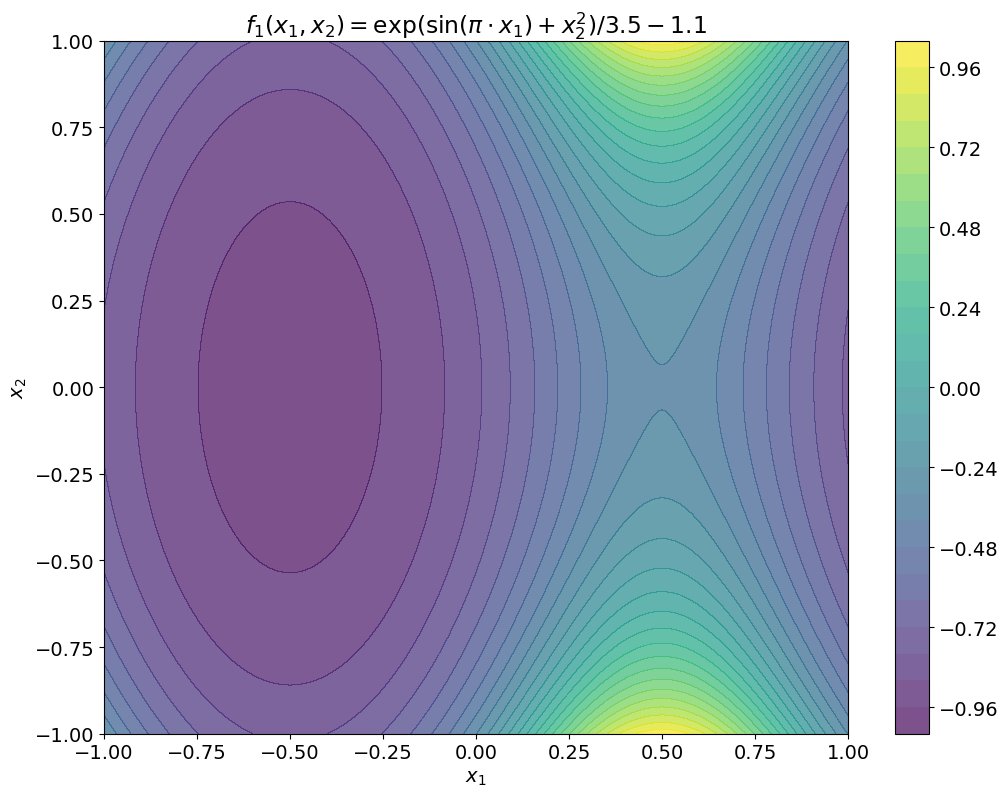

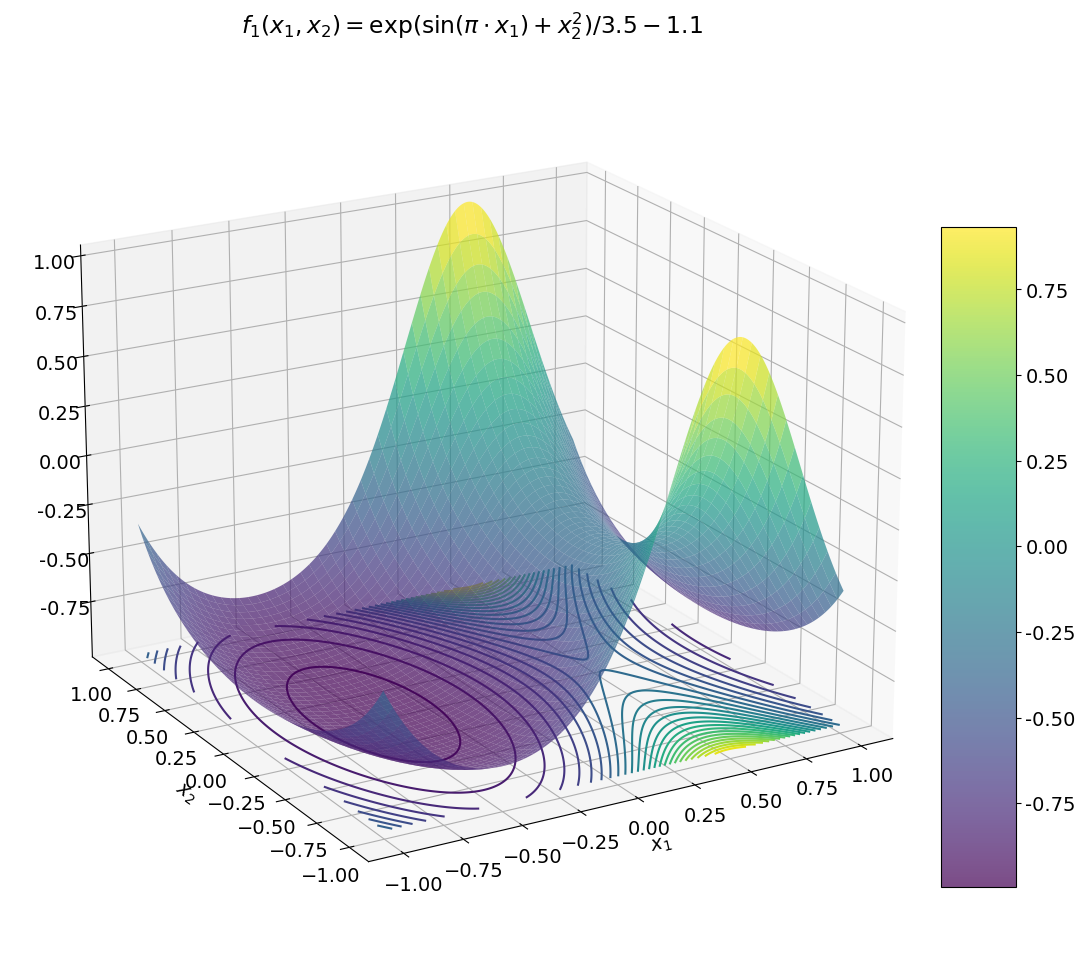

In [14]:
# create dataset
f1 = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2) / 3.5 - 1.1
dataset1 = create_dataset(f1, n_var=2, device=device)

f = f1
dataset = dataset1

plot_f_2d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')
plot_f_3d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')

In [15]:
dataset['test_input'].shape

torch.Size([1000, 2])

## Demo of inter-channel entropy evaluating with gradients evaluating providng.

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 142


| train_loss: 5.48e-02 | test_loss: 6.01e-02 | reg: 1.73e+01 | : 100%|█| 150/150 [01:14<00:00,  2.01


saving model version 0.1


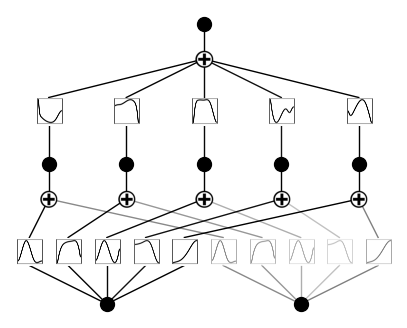

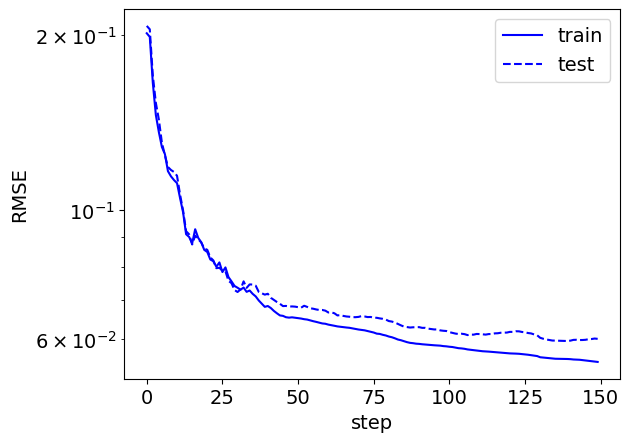

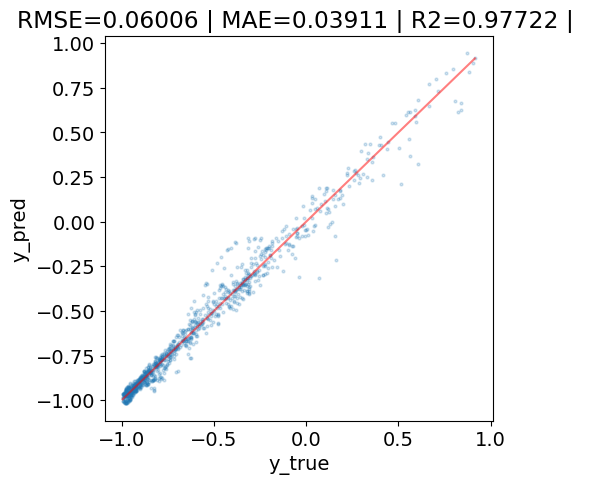

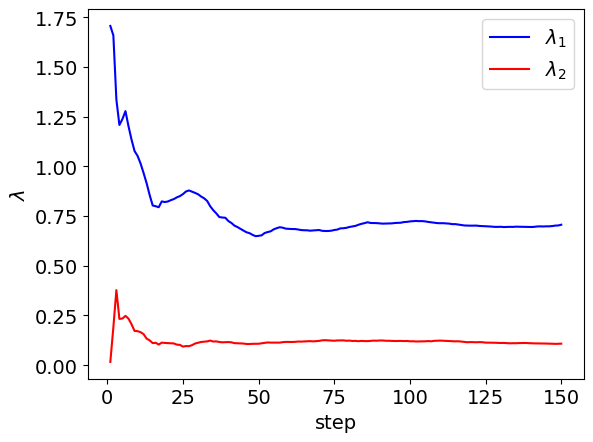

model.act_fun[0].lmd=Parameter containing:
tensor([0.7065, 0.1080], requires_grad=True)


In [17]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[2,5,1], grid=3, k=3, seed=1, device=device, 
               lmd_init_vector=None, lmd_init_mu=0.0, lmd_init_sigma=1.0, lmd_trainable=True)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, update_grid=True, grid_update_num=20)
kan_summary_after_fit(model, dataset, results, lmdKAN=True)
print(f'{model.act_fun[0].lmd=}')

In [18]:
fin_layer = False

lmd_layer_acts_disp_scale = 1
out_layer_acts_disp_scale = 1

# Prepare lmd_layer_acts, out_layer_acts in shape (in_dim, out_dim, N) and (out_dim, N)
if fin_layer:
    lmd_layer_acts, out_layer_acts = model.beforelmd.detach().clone(), model.acts[-1].detach().clone()
else:
    lmd_layer_acts, out_layer_acts = model.beforelmd.detach().clone(), model.spline_postacts[1].detach().clone().squeeze()

lmd_layer_acts = lmd_layer_acts.permute(2, 1, 0) #(in_dim, out_dim, N)
out_layer_acts = out_layer_acts.permute(1, 0) #(out_dim, N)

_in_dim, _out_dim, _N = lmd_layer_acts.shape

lmd_layer_acts.shape, out_layer_acts.shape

(torch.Size([2, 5, 1000]), torch.Size([5, 1000]))

In [26]:
model.acts[-1].shape

torch.Size([1000, 1])

In [19]:
# Prepare std for norming
std_lmd_layer_acts = torch.std(lmd_layer_acts.detach().clone(), dim=-1) * lmd_layer_acts_disp_scale #(in_dim, out_dim)
std_out_layer_acts = torch.std(out_layer_acts.detach().clone(), dim=-1) * out_layer_acts_disp_scale #(out_dim)

std_lmd_layer_acts = std_lmd_layer_acts[:,:, None, None, None] #(in_dim, out_dim, 1, 1, 1)
std_out_layer_acts = std_out_layer_acts[None,:, None, None, None].expand(_in_dim, _out_dim, 1, 1, 1) #(in_dim, out_dim, 1, 1, 1)

std_data_vector = torch.cat((std_lmd_layer_acts, std_out_layer_acts), dim=-1) #(in_dim, out_dim, 1, 1, 2)

std_lmd_layer_acts.shape, std_out_layer_acts.shape, std_data_vector.shape

(torch.Size([2, 5, 1, 1, 1]),
 torch.Size([2, 5, 1, 1, 1]),
 torch.Size([2, 5, 1, 1, 2]))

In [20]:
# Prepare full_data as multiple pairs of (x, y) independently for each function
out_layer_acts = out_layer_acts.expand(1, _in_dim, _out_dim, _N) #(1, in_dim, out_dim, N)
lmd_layer_acts = torch.unsqueeze(lmd_layer_acts, 0) #(1, in_dim, out_dim, N)

out_layer_acts.shape, lmd_layer_acts.shape

(torch.Size([1, 2, 5, 1000]), torch.Size([1, 2, 5, 1000]))

In [21]:
full_data = torch.cat((lmd_layer_acts, out_layer_acts), dim=0) #(2, in_dim, out_dim, N)
full_data = full_data.permute(1, 2, 3, 0) #(in_dim, out_dim, N, 2)
full_data.shape

torch.Size([2, 5, 1000, 2])

In [22]:
# Prepare residuals as matrix of distances independently for x, y and each function
full_data = full_data.unsqueeze(dim=2) #(in_dim, out_dim, 1, N, 2)
residuals = full_data - full_data.detach().clone().swapaxes(-2, -3) #(in_dim, out_dim, N', N, 2); N' - is not differentiable, stands for points in which kernel dencity is estimated

# Norming residuals on std and calculate distances**2
squared_distances = torch.sum(torch.square(residuals / std_data_vector), dim=-1) #(in_dim, out_dim, N', N)
squared_distances.shape

torch.Size([2, 5, 1000, 1000])

In [23]:
from scipy.special import gamma


def radial_function(squared_distances, beta=1, trash_hold_std=None):
    
    if trash_hold_std!=None:
        _squared_distances = squared_distances.detach().clone()
        _trash_hold_mask = _squared_distances * (1 - torch.heaviside(_squared_distances, torch.Tensor([trash_hold_std])))
        
        squared_distances = squared_distances * _trash_hold_mask #(in_dim, out_dim, N', N)
    
    if beta==1:
        c = 1/(2*torch.pi) #norming for each probability (before summing)
        kernel_values = c * torch.exp(-squared_distances / 2) #(in_dim, out_dim, N', N)
        
    else:
        c = beta/(torch.pi * gamma(1/beta) * 2**(1/beta))
        kernel_values = c * torch.exp(-torch.pow(squared_distances, beta) / 2) #(in_dim, out_dim, N', N)
    
    return kernel_values

In [ ]:
# Applying radial_function to squared_distances
kernel_values = radial_function(squared_distances, beta=1, trash_hold_std=3)
kernal_probs = kernel_values.sum(dim=-1)

kernel_values.shape

TypeError: radial_function() got an unexpected keyword argument 'betta'

In [ ]:
# Create _zero_diag_mask to exclude diagonal probs in kernal_probs
_zero_diag_mask = (torch.ones(_N, _N) - torch.eye(_N, _N)) #(N', N)
_zero_diag_mask.shape

torch.Size([1000, 1000])

In [ ]:
# Finally, create and norm kernal_probs
kernal_probs = (_zero_diag_mask * kernel_values).sum(dim=-1) #(in_dim, out_dim, N')

kernal_probs = kernal_probs / torch.sum(kernal_probs.detach().clone(), dim=-1, keepdim=True) #(in_dim, out_dim, N')
kernal_probs.shape

torch.Size([2, 5, 1000])

In [ ]:
# Evaluate negative Entropy from kernal_probs
n_entropy = torch.sum(torch.log(kernal_probs), dim=-1) * 1/_N #(in_dim, out_dim)
n_entropy.shape

torch.Size([2, 5])

In [ ]:
# Average negative Entropy and uae it as regression summand
averaged_n_entropy = torch.mean(n_entropy)
averaged_n_entropy

tensor(-6.9078)